In [1]:
%matplotlib widget

import sys
import os
import time
import math as math
from datetime import datetime
import pickle 
import numpy as np
import astropy as ast
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, Column
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from astropy.time import Time
from photutils.aperture import EllipticalAnnulus, aperture_photometry
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate
import scipy.constants
import scipy.special
import scipy.misc
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.interpolate
from scipy.interpolate import CubicSpline
import glob2
import shutil
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm as tqdm

import cv2

import Utility3_4 as ut

from readMDA_Mod2 import *
from ScanFunctions_plot_mod import *
import mda as mda

import pprint

b = 10**5

#SMALL_SIZE = 15
#MEDIUM_SIZE = 15
#BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


IEX_nData not imported


In [2]:
def kappa(num):
    pathString = 'C:\\Users\\Colin Packard\\PythonWorkspace\\ArgonneClean\\MDA_TEST\\Kappa_00'
    return pathString + str(int(num)) + '.mda'

def kappa_old(num):
    pathString = 'C:\\Users\\Colin Packard\\PythonWorkspace\\ArgonneClean\\OldMDA\\Kappa_00'
    return pathString + str(int(num)) + '.mda'

def get_d_index(fname,detNum,verbose = False):
    data_file  = mda.readMDA(fname, maxdim=4, verbose=0, showHelp=0)
    D={}
    n=len(data_file)-1
    for i in range(0,data_file[n].nd):
        detector=data_file[n].d[i].fieldName
        D[int(detector[1:])]=(data_file[n].d[i].name,i)
        
        if verbose == True:
            print_string = "detNum: " + str(int(detector[1:])) + ", Name: " +  data_file[n].d[i].name + ", d_index: " + str(i)
            print(print_string)
    #if verbose == True:
    #    pprint.pprint(D)
    
    d_index=D[detNum][1]
        
    if verbose == True:
        print("")
        print("Detector " + str(detNum) + " has d_index " + str(d_index))
    
    return d_index

def get_SRS_parameters(data,SRSnum):
    #Returns the gain settings for a given SRS number
    #SRS_1: Mesh
    #SRS_3: Diode D3
    #jessica uses offset_gain_value as offset_value
    
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    
    offset_value = data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL']
    offset_value = offset_value[2][0]
    offset_sign = data[0]['29idd:A'+str(SRSnum)+'offset_sign.VAL']
    offset_sign = offset_sign[2]

    offset_gain_value = data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'] #This is what jessica used for offset_value
    offset_gain_value = offset_gain_value[2]
    offset_gain_unit_string = data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL']
    offset_gain_unit_string = offset_gain_unit_string[2]

    gain = data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL']
    gain = gain[2]
    gain_unit_string = data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL']
    gain_unit_string = gain_unit_string[2]
    
    gain_units = unit_sciNote[gain_unit_string[:-2]]
    offset_gain_units = unit_sciNote[offset_gain_unit_string]
    
    gain = float(gain)
    gain_units = float(gain_units)
    offset_value = float(offset_value)
    offset_gain_value = float(offset_gain_value)
    offset_gain_units = float(offset_gain_units)
    
    return gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string

def get_beam_parameters(data):
    
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    
    slit_size = data[0]['29idb:Slit4Vt2.C'] #'slit3D size'
    slit_size = slit_size[2][0]
    slit_unit_string = 'um' #slit size is given in units of um
    
    polarization = data[0]['ID29:ActualMode']
    polarization = polarization[2] #string

    desired_photon_energy = data[0]['29idmono:ENERGY_SP'] 
    desired_photon_energy_units_string = desired_photon_energy[1] #string
    desired_photon_energy = desired_photon_energy[2][0]
    
    calculated_photon_energies = np.array(data[1].d[2].data)
    calculated_photon_energy = np.mean(calculated_photon_energies)
    std_calculated_photon_energy = np.std(calculated_photon_energies)
    calculated_photon_energy_units_string = data[1].d[2].unit #should be a string
    
    slit_size = float(slit_size)
    desired_photon_energy = float(desired_photon_energy)
    
    return slit_size, slit_unit_string, polarization, desired_photon_energy, desired_photon_energy_units_string, calculated_photon_energy, std_calculated_photon_energy, calculated_photon_energy_units_string
    

    
def calc_current(fname,detNum,subtract_baseline = True):
    """
    returns the current in Amps
    subtract_baseline = True to subtract dark signal
    """
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    #scaler_counts_pv = '29idMZ0:scaler1.TP'
    data = mda.readMDA(fname)
    d_index = get_d_index(fname,detNum,verbose = False)
    scaler_value = np.array(data[1].d[d_index].data)
    
    SRS_Dict = {31:1,32:2,33:3,34:4}
    SRSnum = SRS_Dict[detNum]
    
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
   
    current_Amp = scaler_value * gain * gain_units/b
    #baseline = offset_value * offset_gain_value * offset_gain_units
    baseline = offset_value * offset_gain_units #This is how Jessica did it.
    
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")
    

    if subtract_baseline:
        #print("Baseline: " + str(baseline/1e-12) + " [pA]")
        current_Amp = current_Amp + baseline #This is the way Jessica had it
        #current_Amp = current_Amp - baseline #The alternative
        
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")

    return current_Amp

def calc_current_given_gain(fname,detNum,gain,gain_unit_string,subtract_baseline = True):
    """
    returns the current in Amps
    subtract_baseline = True to subtract dark signal
    """
    data = mda.readMDA(fname)
    d_index = get_d_index(fname,detNum,verbose = False)
    scaler_value = np.array(data[1].d[d_index].data)
    
    SRS_Dict = {31:1,32:2,33:3,34:4}
    SRSnum = SRS_Dict[detNum]
    
    unit = {'pA/V':1e-12, 'nA/V':1e-9, 'uA/V':1e-6, 'mA/V':1e-3}
    gain_units = unit[gain_unit_string]
    
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
   
    current_Amp = scaler_value * gain * gain_units/b
    #baseline = offset_value * offset_gain_value * offset_gain_units
    #baseline = offset_value * offset_gain_units #This is how Jessica did it.

    #if subtract_baseline:
        #print("Baseline: " + str(baseline/1e-12) + " [pA]")
        #current_Amp = current_Amp + baseline #This is the way Jessica had it
        #current_Amp = current_Amp - baseline #The alternative
        
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")

    return current_Amp

def find_current_array_pA(scalar_value,gain,gain_unit_string):
    
    unit = {'pA/V':1e-12, 'nA/V':1e-9, 'uA/V':1e-6, 'mA/V':1e-3}
    gain_units = unit[gain_unit_string]
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
    current_Amp = scalar_value * gain * gain_units/b
    
    current_pA = current_Amp/unit['pA/V']
    
    mean_current_pA = np.mean(current_pA)
    mean_current_pA_string ="{:e}".format(mean_current_pA) + " [pA]"
    
    std_current_pA = np.std(current_pA)
    std_current_pA_string = "{:e}".format(std_current_pA) + " [pA]"
    
    return current_pA, mean_current_pA, std_current_pA, mean_current_pA_string, std_current_pA_string

def find_current_array_dark_subtract(scalar_value,gain,gain_unit_string,scalar_value_dark,gain_dark,gain_unit_string_dark):
    
    current_pA_light, mean_current_pA_light, std_current_pA_light, mean_current_pA_string, std_current_pA_string = find_current_array_pA(scalar_value,gain,gain_unit_string)
    current_pA_dark, mean_current_pA_dark, std_current_pA_dark, mean_current_pA_string, std_current_pA_string = find_current_array_pA(scalar_value_dark,gain_dark,gain_unit_string_dark)
    
    mean_current_pA = mean_current_pA_light - mean_current_pA_dark
    std_current_pA = std_current_pA_light #the dark noise is baked in to the light std
    
    mean_current_pA_string ="{:e}".format(mean_current_pA) + " [pA]"
    std_current_pA_string = "{:e}".format(std_current_pA) + " [pA]"
    
    return mean_current_pA, std_current_pA, mean_current_pA_string, std_current_pA_string

In [3]:
def get_sec(time_str):
    """Get seconds from time."""
    m, s = time_str.split(':')
    return float(m) * 60 + float(s)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_current_basic2(scalar_value,gain,gain_unit_string):
    
    unit = {'pA/V':1e-12, 'nA/V':1e-9, 'uA/V':1e-6, 'mA/V':1e-3}
    gain_units = unit[gain_unit_string]
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
    current_Amp = scalar_value * gain * gain_units/b
    
    current_pA = current_Amp/unit['pA/V']
    
    current_pA_string ="{:e}".format(current_pA) + " [pA]"
    
    return current_pA_string, current_pA

def Err_a_over_b(a,b,err_a,err_b):
    A = (err_a/b)**2
    B = (a*err_b/(b**2))**2
    return(np.sqrt(A+B))

def calc_current_MeshTS(fname,detNum,MeshCountsArray,subtract_baseline = True):
    """
    returns the current in Amps
    subtract_baseline = True to subtract dark signal
    #Creating a modifed current calculating function to take in the mesh counts array and the kappa number seperately,
    #That way gain values from one kappa can be used with mesh currents from another time series. 
    #This is important because for the long mesh time series, no gain values were actually recorded, and we assume the values from
    #the previous kappa.
    """
    unit_sciNote = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
    #scaler_counts_pv = '29idMZ0:scaler1.TP'
    data = mda.readMDA(fname)
    d_index = get_d_index(fname,detNum,verbose = False)
    scaler_value = MeshCountsArray
    
    SRS_Dict = {31:1,32:2,33:3,34:4}
    SRSnum = SRS_Dict[detNum]
    
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    b = 10**5 #counts/v or counts/s/v depending on if the photodiode was recording counts over second long intervals
   
    current_Amp = scaler_value * gain * gain_units/b
    #baseline = offset_value * offset_gain_value * offset_gain_units
    baseline = offset_value * offset_gain_units
    
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")
    

    if subtract_baseline:
        print("Baseline: " + str(baseline/1e-12) + " [pA]")
        #current_Amp = current_Amp + baseline
        current_Amp = current_Amp - baseline
        
    #print("Mean Current: " + str(np.mean(current_Amp/1e-12)) + " [pA]")

    return current_Amp

    
def PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    ax[1,0].plot(Positioner,DetCounts, color="navy")
    ax[1,0].set_title(DetName + " Counts", loc = 'center')
    ax[1,0].set_xlabel('Elapsed Time [sec]')
    ax[1,0].set_ylabel('Counts/s')
    #yticks1 = ax[0].get_yticks()
    #ax[0].set_yticklabels(FormatStrFormatter('%.2f').format_ticks(yticks1))
    ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[0,0].set_aspect(0.5)
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
        
def PlotGraphs_BS(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    ax[1,0].plot(Positioner,DetCounts, color="navy")
    ax[1,0].set_title(DetName + " Counts", loc = 'center')
    ax[1,0].set_xlabel('Elapsed Time [sec]')
    ax[1,0].set_ylabel('Counts/s')
    #yticks1 = ax[0].get_yticks()
    #ax[0].set_yticklabels(FormatStrFormatter('%.2f').format_ticks(yticks1))
    ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[0,0].set_aspect(0.5)
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
    
    
def PlotGraphsUPD(KappaNum,KappaDesc,DetName,Positioner,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,0].set_xticks(())
    ax[1,0].set_yticks(())
    ax[1,0].set(frame_on=False)
    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        #ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(No Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
        
def PlotGraphsUPD_BS(KappaNum,KappaDesc,DetName,Positioner,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName = False):
    
    #set_aspect num => height = num * width
    #ax.set_aspect(0.5) => half height rectangles 
    
    #f, ax = plt.subplots(1, 4)
    f, ax = plt.subplots(2, 3)
    #plt.clf()
    
    ax[1,1].plot(Positioner,MeshCounts, color="navy")
    ax[1,1].set_title(r"Mesh Counts", loc = 'center')
    ax[1,1].set_xlabel('Elapsed Time [sec]')
    ax[1,1].set_ylabel('Counts/s')
    ax[1,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,0].set_aspect(0.5)
    
    ax[0,2].plot(Positioner,StorageLoopCurrent, color="navy")
    ax[0,2].set_title("Storage Ring Current", loc = 'center')
    ax[0,2].set_xlabel('Elapsed Time [sec]')
    ax[0,2].set_ylabel('Current [mA]')

    ax[0,0].plot(Positioner,DetCurrent/1e-12, color="navy")
    #ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
    ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,0].set_xlabel('Elapsed Time [sec]')
    ax[0,0].set_ylabel('Current [pA]')
    #ax[0,1].set_aspect(0.5)

    ax[0,1].plot(Positioner,MeshCurrent/1e-12, color="navy")
    ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center')
    ax[0,1].set_xlabel('Elapsed Time [sec]')
    ax[0,1].set_ylabel('Current [pA]')
    ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax[1,1].set_aspect(0.5)

    
    ax[1,0].set_xticks(())
    ax[1,0].set_yticks(())
    ax[1,0].set(frame_on=False)
    
    ax[1,2].set_xticks(())
    ax[1,2].set_yticks(())
    ax[1,2].set(frame_on=False)

    plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
    plt.subplots_adjust(top=0.8)
    
    figure = plt.gcf()
    figure.tight_layout()
    
    if SaveName == False:
        
        #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        #ax[1,0].set_title(DetName + " Counts", loc = 'center', pad=20)
        ax[1,1].set_title(r"Mesh Counts", loc = 'center', pad=20)
        ax[0,2].set_title("Storage Ring Current", loc = 'center', pad=20)
        ax[0,0].set_title(r"" + DetName+ " Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        ax[0,1].set_title(r"Mesh Current"
                 "\n" r"(With Baseline Subtraction)", loc = 'center', pad=20)
        
        figure.set_size_inches(9.5, 7)
    

In [4]:
def print_SRS_parameters(data,KappaNum,KappaDesc):
    
    #Getting and Printing D3 Photodiode Parameters
    SRSnum = 3 #detNum = 33
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    #title_string = "Gain Settings for Kappa " + str(KappaNum) + ": " + KappaDesc
    #print(title_string)
    #print("-------------------------------------------------------------------------")
    print("Gain Settings:")
    print("")
    print("SRS_3 (D3 Photodiode)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    
    #Getting and Printing Mesh Parameters
    SRSnum = 1 #detNum = 31
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    print("")
    print("SRS_1 (Mesh)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    print("")
    print("*(Jessica uses this as just offset in her code.)")
    
    
def print_beam_parameters(data):
    
    slit_size, slit_unit_string, polarization, desired_photon_energy, desired_photon_energy_units_string, calculated_photon_energy, std_calculated_photon_energy, calculated_photon_energy_units_string =  get_beam_parameters(data)
    
    
    slit_size_string = str(slit_size) + " [" + slit_unit_string + "]" + ' (29idb:Slit4Vt2.C)'
    slit_size_string = slit_size_string + " (" + data[0]['29idb:Slit4Vt2.C'][0] + ")"
    polarization_string = polarization + "      (ID29:ActualMode)" 
    polarization_string = polarization_string + " (" + data[0]['ID29:ActualMode'][0] + ")"
    desired_photon_energy_string = str(desired_photon_energy) + " [" + desired_photon_energy_units_string + "]" + ' (29idmono:ENERGY_SP)'
    desired_photon_energy_string= desired_photon_energy_string + " (" + data[0]['29idmono:ENERGY_SP'][0] + ")"
    calculated_photon_energy_string = str(round(calculated_photon_energy,3)) + " +/- "+ str(round(std_calculated_photon_energy,3)) + " [" + calculated_photon_energy_units_string + "]" + '(29idmono:ENERGY_MON)'
    calculated_photon_energy_string = calculated_photon_energy_string + " (" + data[0]['29idmono:ENERGY_MON'][0] + ")"
    
    #print("-------------------------------------------------------------------------")
    print("Beam Parameters:")
    print("")
    print("RSXS Branch, MEG")
    print("---------------------------------------------------")
    print("Slit:                     " + slit_size_string )
    print("Polarization:             " + polarization_string)
    print("Desired Photon Energy:    " + desired_photon_energy_string )
    print("Calculated Photon Energy: " + calculated_photon_energy_string)
    
def print_SRS_parametersUPD(data,KappaNum,KappaDesc):
    
    #Getting and Printing D3 Photodiode Parameters
    #SRSnum = ? #detNum = 63
    #gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    #gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    #gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    #offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    #offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    #offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    #offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    #title_string = "Gain Settings for Kappa " + str(KappaNum) + ": " + KappaDesc
    #print(title_string)
    #print("-------------------------------------------------------------------------")
    print("Gain Settings:")
    print("")
    print("SRS_? (Uncoated Photodiode)")
    print("---------------------------------------------------")
    print("Gain:         ?")
    print("Offset:       ?")
    print("Offset Gain*: ?")
    
    #Getting and Printing Mesh Parameters
    SRSnum = 1 #detNum = 31
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    print("")
    print("SRS_1 (Mesh)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    print("")
    print("*(Jessica uses this as just offset in her code.)") 
    
def print_SRS_parametersLTS(data,KappaNum):
    
    #Getting and Printing Mesh Parameters
    SRSnum = 1 #detNum = 31
    gain, gain_units, offset_value, offset_gain_value, offset_gain_units, gain_unit_string, offset_gain_unit_string = get_SRS_parameters(data,SRSnum)
    
    gain_string = str(gain) + " [" + gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'sens_num.VAL, 29idd:A'+str(SRSnum)+'sens_unit.VAL)'
    gain_string = gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'sens_num.VAL'][0] +", " +data[0]['29idd:A'+str(SRSnum)+'sens_unit.VAL'][0] + ")"
    offset_string = str(offset_value) + " [?]" + ' (29idd:A'+str(SRSnum)+'off_u_put.VAL)'
    offset_string = offset_string + "                     (" + data[0]['29idd:A'+str(SRSnum)+'off_u_put.VAL'][0] + ")"
    offset_gain_string = str(offset_gain_value) + " [" + offset_gain_unit_string + "]" + ' (29idd:A'+str(SRSnum)+'offset_num.VAL, 29idd:A'+str(SRSnum)+'offset_unit.VAL)'
    offset_gain_string = offset_gain_string + " (" + data[0]['29idd:A'+str(SRSnum)+'offset_num.VAL'][0] +", " + data[0]['29idd:A'+str(SRSnum)+'offset_unit.VAL'][0] + ")"
    
    print("")
    print("SRS_1 (Mesh)")
    print("---------------------------------------------------")
    print("Gain:         " + gain_string )
    print("Offset:       " + offset_string )
    print("Offset Gain*: " + offset_gain_string)
    print("")
    print("*(Jessica uses this as just offset in her code.)") 

_________________________________________________________________________________________________
Kappa 42: Open Shutter Relflected Beam Position Time Series
-------------------------------------------------------------------------
Beam Parameters:

RSXS Branch, MEG
---------------------------------------------------
Slit:                     200.0 [um] (29idb:Slit4Vt2.C) (slit3D size)
Polarization:             V      (ID29:ActualMode) (polarization)
Desired Photon Energy:    490.5 [eV] (29idmono:ENERGY_SP) (Desired Photon Energy)
Calculated Photon Energy: 490.499 +/- 0.005 [eV](29idmono:ENERGY_MON) (Calculated Photon Energy)
-------------------------------------------------------------------------
Gain Settings:

SRS_3 (D3 Photodiode)
---------------------------------------------------
Gain:         100.0 [pA/V] (29idd:A3sens_num.VAL, 29idd:A3sens_unit.VAL) (SRS_3 Gain Value, SRS_3 Gain Unit)
Offset:       -35.0 [?] (29idd:A3off_u_put.VAL)                     (SRS_3 Offset Value)
Offs

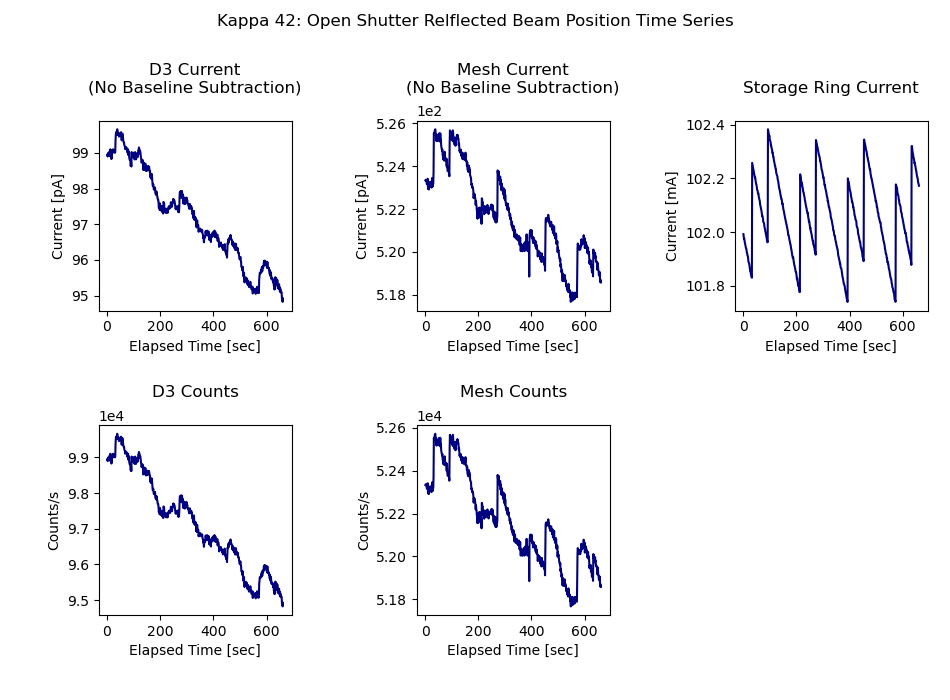

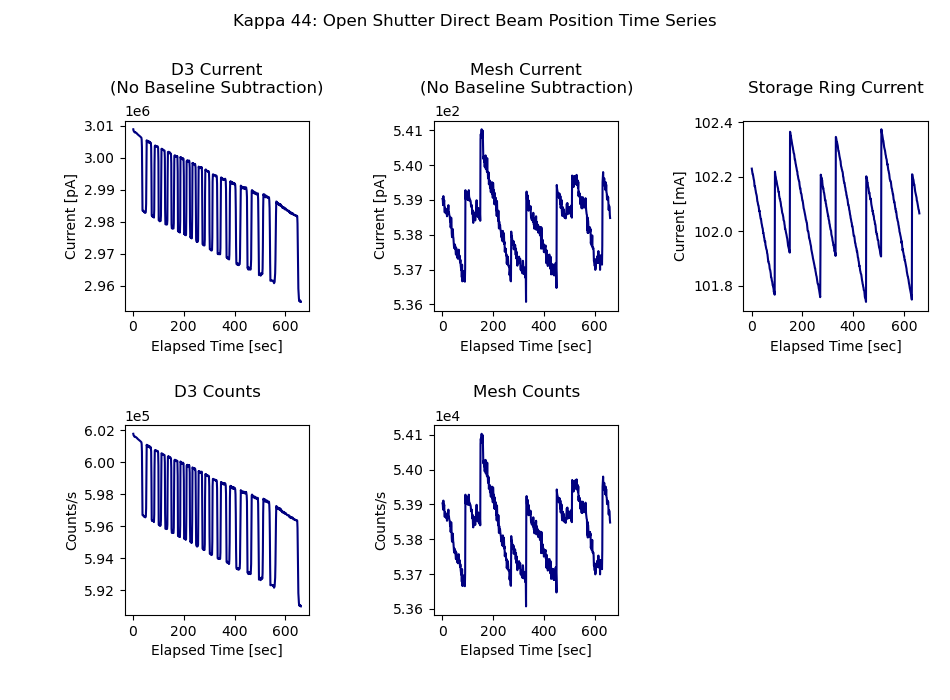

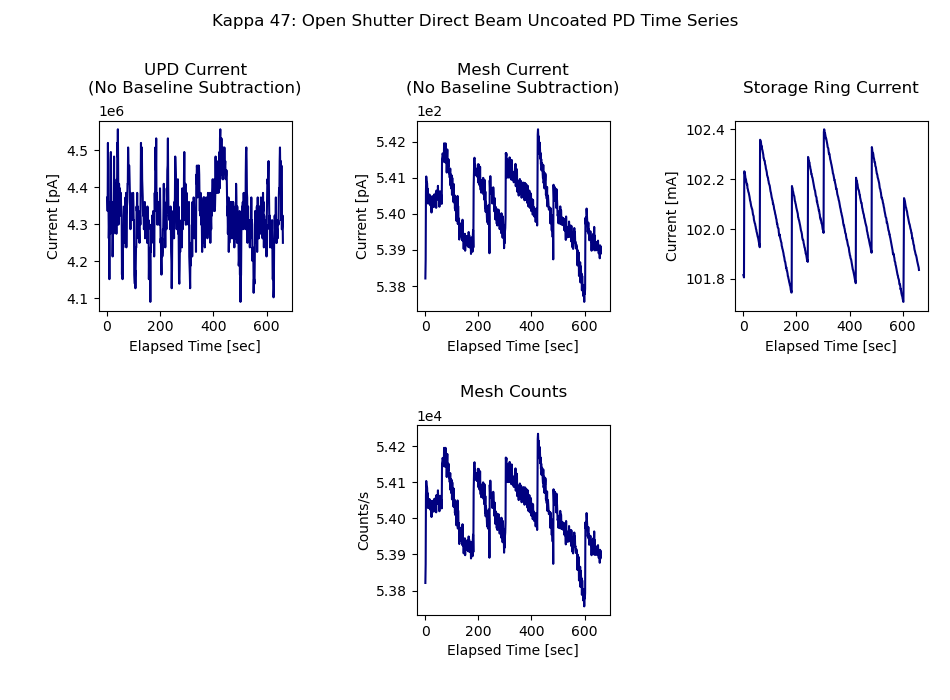

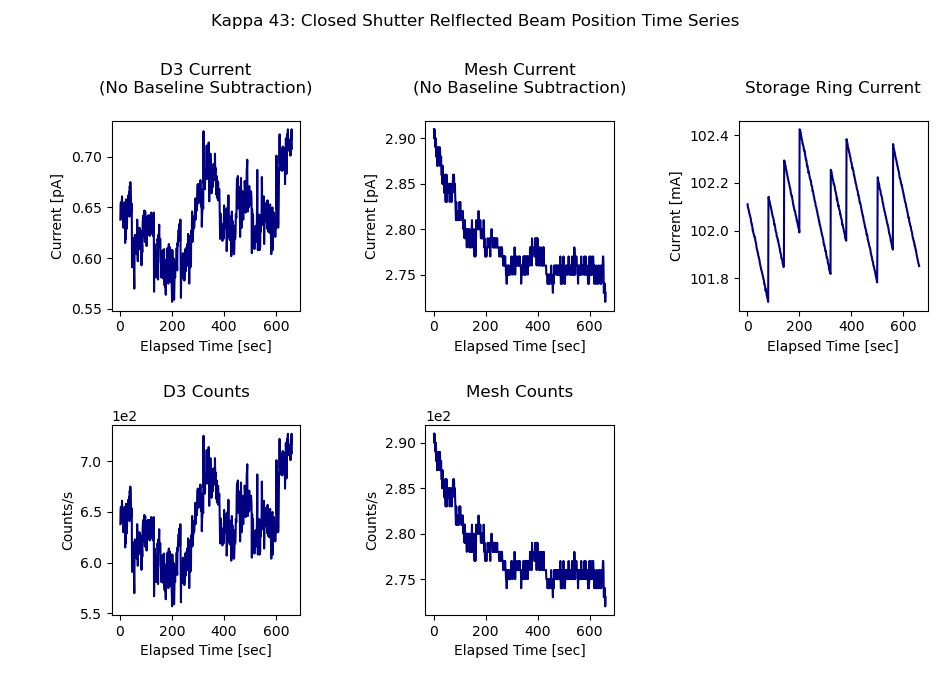

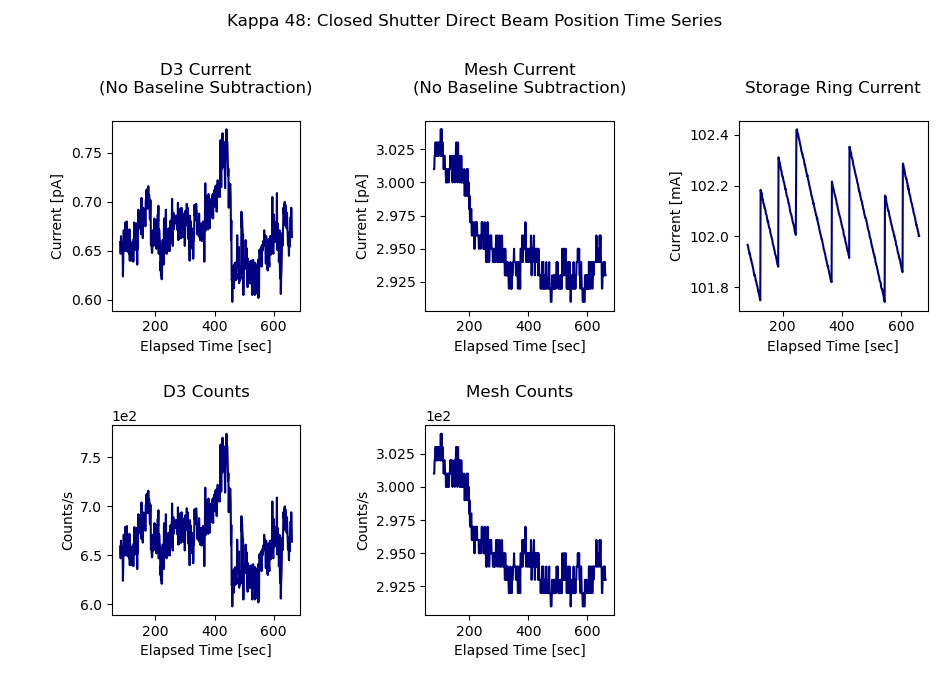

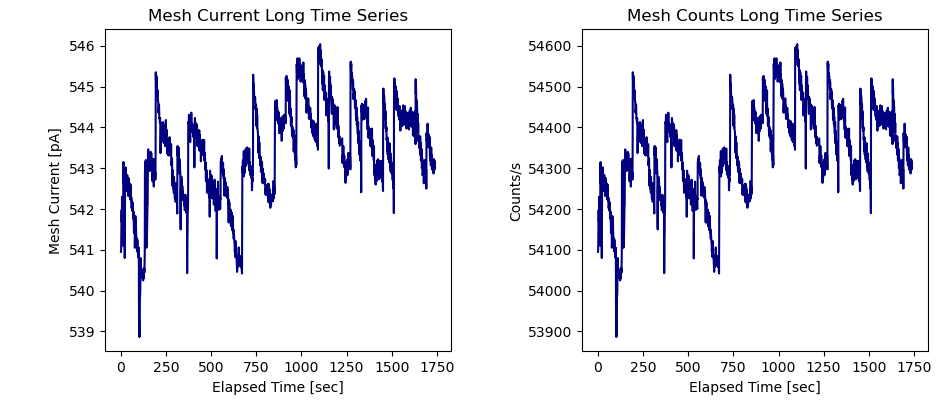

In [5]:
#All currents are in Amps except storage loop current which is in mA
#-------------------------------------------------------------------------------------------------
#Kappa 42
#Open Shutter Relflected Beam Position Time Series
kappaNum = 42
kappaDesc = "Open Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K42_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K42_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K42_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K42_D3_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K42_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K42_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 43
#Closed Shutter Relflected Beam Position Time Series
kappaNum = 43
kappaDesc = "Closed Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K43_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K43_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K43_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K43_D3_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K43_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K43_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 44
#Open Shutter Direct Beam Position Time Series
kappaNum = 44
kappaDesc = "Open Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K44_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K44_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K44_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction) (Using Best Guess for Gain, because the gain in the meta data is clearly wrong)
detNum = 33
gain_K44 = 500
gain_unit_string_K44 = 'nA/V'

K44_D3_Current_No_BS = calc_current_given_gain(kappa(kappaNum),detNum,gain_K44,gain_unit_string_K44,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K44_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K44_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 48
#Closed Shutter Direct Beam Position Time Series
kappaNum = 48
kappaDesc = "Closed Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K48_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa(kappaNum),detNum)
K48_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K48_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K48_D3_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K48_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K48_Storage_Loop_Current=data[1].d[d_index].data

#The time series started before the shutter was completely closed, so we start at index 73
K48_Positioner = K48_Positioner[73:]
K48_D3_Counts = K48_D3_Counts[73:]
K48_Mesh_Counts = K48_Mesh_Counts[73:]
K48_D3_Current_No_BS = K48_D3_Current_No_BS[73:]
K48_Mesh_Current_No_BS = K48_Mesh_Current_No_BS[73:]
K48_Storage_Loop_Current = K48_Storage_Loop_Current[73:]
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 47
#Open Shutter Direct Beam Uncoated PD Time Series
kappaNum = 47
kappaDesc = "Open Shutter Direct Beam Uncoated PD Time Series"
data = mda.readMDA(fname=kappa(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K47_Positioner =data[1].p[0].data

#Uncoated Photodiode Counts
#detNum = 63
#d_index = get_d_index(kappa(kappaNum),detNum)
#K47_UPD_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa(kappaNum),detNum)
K47_Mesh_Counts=data[1].d[d_index].data

#Uncoated Photodiode Current
detNum = 63
d_index = get_d_index(kappa(kappaNum),detNum)
K47_UPD_Current=data[1].d[d_index].data

#Mesh Current (No Baseline Subtraction)
detNum = 31
K47_Mesh_Current_No_BS = calc_current(kappa(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current [mA]
detNum = 1
d_index = get_d_index(kappa(kappaNum),detNum)
K47_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Mesh Current Long Time Series
MeshCurrentTable = Table.read('mesh_current.csv', format='ascii.csv')

TimesArray = np.array(MeshCurrentTable['Time'])
MeshCountArray = np.array(MeshCurrentTable['Mesh_Current'])

#Convert Times to elapsed seconds
TimesList = []
for i in range(np.size(TimesArray)):
    TimesList.append(get_sec(TimesArray[i]))
TimesArraySec = np.array(TimesList)

#Truncate both time and counts arrays at the turn of the hour
#The time is only recorded up to 60 minutes, before looping back to 0 minutes,
#but there was no real data before the turn of the 1st hour anyways because we forgot to open the main shutter for a while
#and we don't get to the turn of the second hour before the timeseries ends.

NewTimesArray = TimesArraySec[find_nearest(TimesArraySec, 0):]
NewTimesArray = NewTimesArray - NewTimesArray[0]

NewMeshCountArray = MeshCountArray[find_nearest(TimesArraySec, 0):]

#Now I truncate again at 1050 seconds elapsed time because I remember there being funny business that I knew I had to cut out.
#I pick 1050 seconds based on a plot from earlier versions of this code that is excluded here for brevity.
FinalTimesArray = NewTimesArray[find_nearest(NewTimesArray, 1050):]
FinalTimesArray = FinalTimesArray - FinalTimesArray[0]
LTS_Positioner = FinalTimesArray

FinalMeshCountArray = NewMeshCountArray[find_nearest(NewTimesArray, 1050):]
LTS_Mesh_Counts = FinalMeshCountArray

#Calculate the Current
#Reuse the mesh gain values from Kappa 48, the most recent Kappa time series
kappaNum = 48
detNum = 31
LTS_Mesh_Current_No_BS = calc_current_MeshTS(kappa(kappaNum),detNum,FinalMeshCountArray,subtract_baseline = False)
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------

#All currents are in Amps except for Storage loop currents, which are in mA
#-------------------------------------------------------------------------------------------------
#Kappa 42
#Open Shutter Relflected Beam Position Time Series
OS_R_Positioner = np.array(K42_Positioner)
OS_R_D3_Counts = np.array(K42_D3_Counts)
OS_R_Mesh_Counts = np.array(K42_Mesh_Counts)
OS_R_D3_Current = np.array(K42_D3_Current_No_BS)
OS_R_Mesh_Current = np.array(K42_Mesh_Current_No_BS)
OS_R_Storage_Loop_Current = np.array(K42_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 43
#Closed Shutter Relflected Beam Position Time Series
CS_R_Positioner = np.array(K43_Positioner)
CS_R_D3_Counts = np.array(K43_D3_Counts)
CS_R_Mesh_Counts = np.array(K43_Mesh_Counts)
CS_R_D3_Current = np.array(K43_D3_Current_No_BS)
CS_R_Mesh_Current = np.array(K43_Mesh_Current_No_BS)
CS_R_Storage_Loop_Current = np.array(K43_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 44
#Open Shutter Direct Beam Position Time Series
OS_D_Positioner = np.array(K44_Positioner)
OS_D_D3_Counts = np.array(K44_D3_Counts)
OS_D_Mesh_Counts = np.array(K44_Mesh_Counts)
OS_D_D3_Current = np.array(K44_D3_Current_No_BS)
OS_D_Mesh_Current = np.array(K44_Mesh_Current_No_BS)
OS_D_Storage_Loop_Current = np.array(K44_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 48
#Closed Shutter Direct Beam Position Time Series
CS_D_Positioner = np.array(K48_Positioner)
CS_D_D3_Counts = np.array(K48_D3_Counts)
CS_D_Mesh_Counts = np.array(K48_Mesh_Counts)
CS_D_D3_Current = np.array(K48_D3_Current_No_BS)
CS_D_Mesh_Current = np.array(K48_Mesh_Current_No_BS)
CS_D_Storage_Loop_Current = np.array(K48_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 47
#Open Shutter Direct Beam Uncoated PD Time Series
OS_UPD_Positioner = np.array(K47_Positioner)
OS_UPD_Mesh_Counts = np.array(K47_Mesh_Counts)
OS_UPD_Current = np.array(K47_UPD_Current)
OS_UPD_Mesh_Current = np.array(K47_Mesh_Current_No_BS)
OS_UPD_Storage_Loop_Current = np.array(K47_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Mesh Current Long Time Series
LTS_Positioner = np.array(LTS_Positioner)
LTS_Mesh_Counts = np.array(LTS_Mesh_Counts)
LTS_Mesh_Current = np.array(LTS_Mesh_Current_No_BS)
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 42
#Open Shutter Relflected Beam Position Time Series
KappaNum = 42
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 44
#Open Shutter Direct Beam Position Time Series
KappaNum = 44
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Kappa 47
#Open Shutter Direct Beam Uncoated PD Time Series
KappaNum = 47
KappaDesc = "Open Shutter Direct Beam Uncoated PD Time Series"
DetName = "UPD"
Positioner = OS_UPD_Positioner
MeshCounts = OS_UPD_Mesh_Counts
DetCurrent = OS_UPD_Current
MeshCurrent = OS_UPD_Mesh_Current
StorageLoopCurrent = OS_UPD_Storage_Loop_Current
SaveName = False

PlotGraphsUPD(KappaNum,KappaDesc,DetName,Positioner,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 43
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 43
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Kappa 48
#Closed Shutter Direct Beam Position Time Series
KappaNum = 48
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Long Mesh Time Series
f, ax = plt.subplots(1, 2)
#plt.clf()
ax[0].plot(LTS_Positioner,LTS_Mesh_Current/1e-12, color="navy")
ax[0].set_title("Mesh Current Long Time Series", loc = 'center')
ax[0].set_xlabel('Elapsed Time [sec]')
ax[0].set_ylabel('Mesh Current [pA]')

ax[1].plot(LTS_Positioner,LTS_Mesh_Counts, color="navy")
ax[1].set_title("Mesh Counts Long Time Series", loc = 'center')
ax[1].set_xlabel('Elapsed Time [sec]')
ax[1].set_ylabel('Counts/s')
#ax.legend()
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(9.5, 4)
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Printing Kappa 42 Info
#Open Shutter Relflected Beam Position Time Series
KappaNum = 42
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("_________________________________________________________________________________________________")
print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 44 Info
#Open Shutter Direct Beam Position Time Series
KappaNum = 44
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)


print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

Gain = 500
Gain_unit_string = 'nA/V'

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

#print_SRS_parameters_K44(data,KappaNum,KappaDesc,Gain,Gain_unit_string)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 47 Info
#Open Shutter Direct Beam Uncoated PD Time Series
KappaNum = 47
KappaDesc = "Open Shutter Direct Beam Uncoated PD Time Series"
DetName = "UPD"
Positioner = OS_UPD_Positioner
MeshCounts = OS_UPD_Mesh_Counts
#DetCounts = OS_UPD_Counts
DetCurrent = OS_UPD_Current
MeshCurrent = OS_UPD_Mesh_Current
StorageLoopCurrent = OS_UPD_Storage_Loop_Current
SaveName = False

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parametersUPD(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  ? [?]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 43 Info
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 43
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 48 Info
#Closed Shutter Direct Beam Position Time Series
KappaNum = 48
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Long Time Series Info

KappaNum = 47 #The most recent time series with metadata
Positioner = LTS_Positioner
MeshCounts = LTS_Mesh_Counts
MeshCurrent = LTS_Mesh_Current

SaveName = False

data = mda.readMDA(fname=kappa(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Long Mesh Current Time Series")
print("-------------------------------------------------------------------------")

print_SRS_parametersLTS(data,KappaNum)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  N/A")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: N/A")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")



_________________________________________________________________________________________________
Kappa 67: Open Shutter Relflected Beam Position Time Series
-------------------------------------------------------------------------
Beam Parameters:

RSXS Branch, MEG
---------------------------------------------------
Slit:                     200.0 [um] (29idb:Slit4Vt2.C) (slit3D size)
Polarization:             H      (ID29:ActualMode) (polarization)
Desired Photon Energy:    490.0 [eV] (29idmono:ENERGY_SP) (Desired Photon Energy)
Calculated Photon Energy: 490.001 +/- 0.005 [eV](29idmono:ENERGY_MON) (Calculated Photon Energy)
-------------------------------------------------------------------------
Gain Settings:

SRS_3 (D3 Photodiode)
---------------------------------------------------
Gain:         1.0 [pA/V] (29idd:A3sens_num.VAL, 29idd:A3sens_unit.VAL) (SRS_3 Gain Value, SRS_3 Gain Unit)
Offset:       -7.0 [?] (29idd:A3off_u_put.VAL)                     (SRS_3 Offset Value)
Offset 

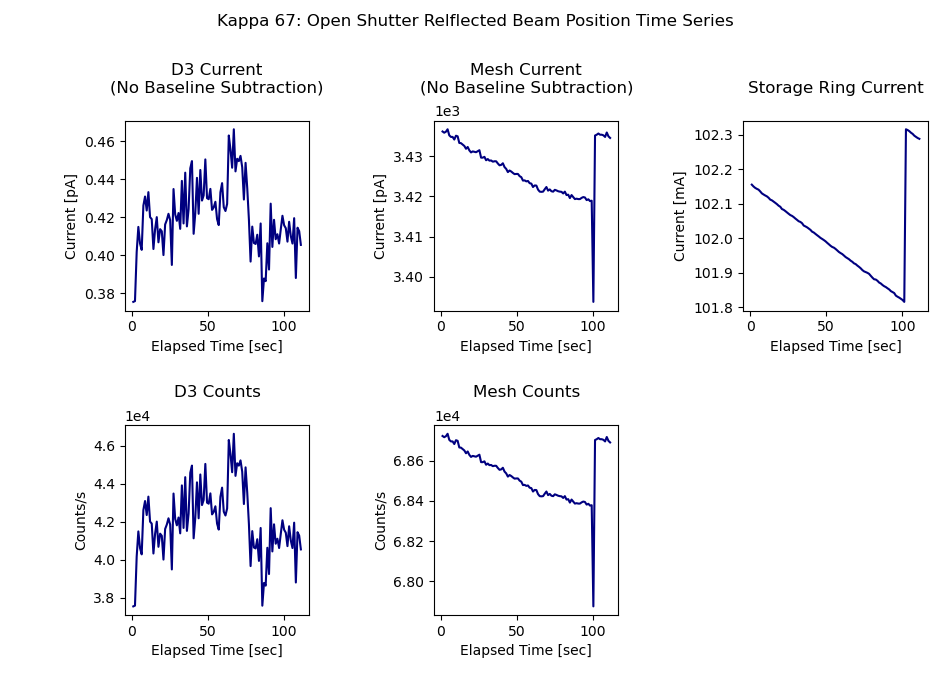

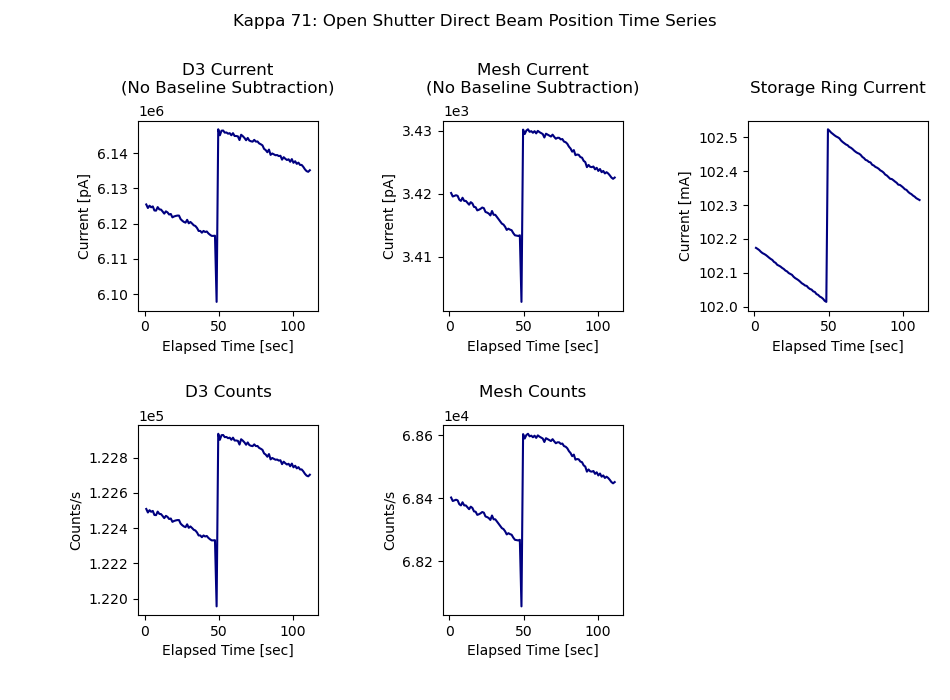

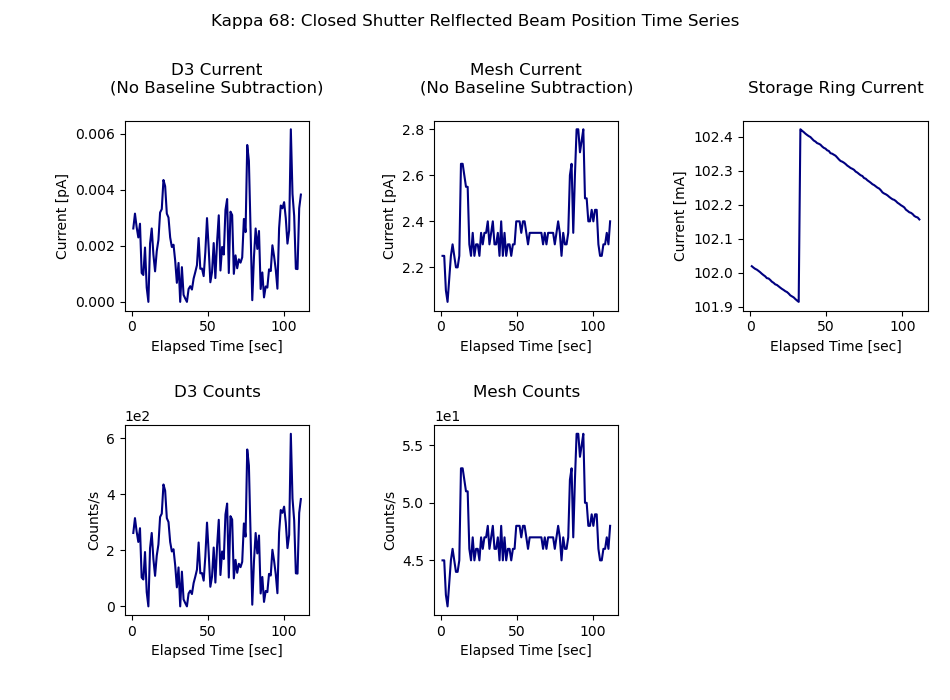

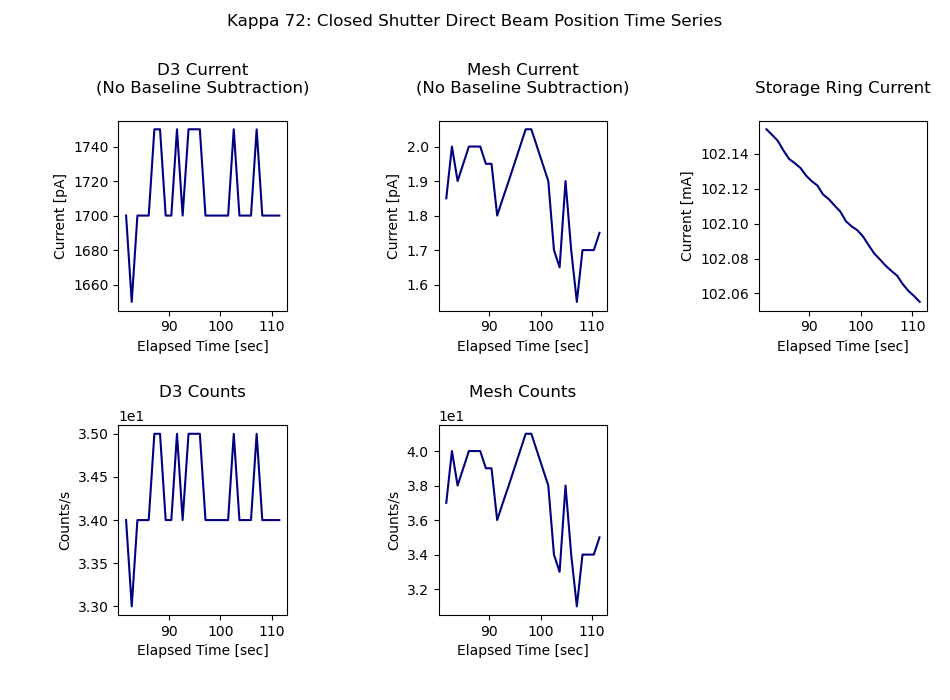

In [6]:
#All currents are in Amps except storage loop current which is in mA
#-------------------------------------------------------------------------------------------------
#Kappa 67
#Open Shutter Relflected Beam Position Time Series
kappaNum = 67
kappaDesc = "Open Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K67_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K67_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K67_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K67_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K67_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K67_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 68
#Closed Shutter Relflected Beam Position Time Series
kappaNum = 68
kappaDesc = "Closed Shutter Relflected Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K68_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K68_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K68_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K68_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K68_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K68_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 71
#Open Shutter Direct Beam Position Time Series
kappaNum = 71
kappaDesc = "Open Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K71_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K71_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K71_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K71_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K71_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K71_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 72
#Closed Shutter Direct Beam Position Time Series
kappaNum = 72
kappaDesc = "Closed Shutter Direct Beam Position Time Series"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K72_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K72_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K72_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K72_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K72_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K72_Storage_Loop_Current=data[1].d[d_index].data

#The time series started before the shutter was completely closed, so we start at index 73
K72_Positioner = K72_Positioner[73:]
K72_D3_Counts = K72_D3_Counts[73:]
K72_Mesh_Counts = K72_Mesh_Counts[73:]
K72_D3_Current_No_BS = K72_D3_Current_No_BS[73:]
K72_Mesh_Current_No_BS = K72_Mesh_Current_No_BS[73:]
K72_Storage_Loop_Current = K72_Storage_Loop_Current[73:]
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------

#All currents are in Amps except for Storage loop currents, which are in mA
#-------------------------------------------------------------------------------------------------
#Kappa 67
#Open Shutter Relflected Beam Position Time Series
OS_R_Positioner = np.array(K67_Positioner)
OS_R_D3_Counts = np.array(K67_D3_Counts)
OS_R_Mesh_Counts = np.array(K67_Mesh_Counts)
OS_R_D3_Current = np.array(K67_D3_Current_No_BS)
OS_R_Mesh_Current = np.array(K67_Mesh_Current_No_BS)
OS_R_Storage_Loop_Current = np.array(K67_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 68
#Closed Shutter Relflected Beam Position Time Series
CS_R_Positioner = np.array(K68_Positioner)
CS_R_D3_Counts = np.array(K68_D3_Counts)
CS_R_Mesh_Counts = np.array(K68_Mesh_Counts)
CS_R_D3_Current = np.array(K68_D3_Current_No_BS)
CS_R_Mesh_Current = np.array(K68_Mesh_Current_No_BS)
CS_R_Storage_Loop_Current = np.array(K68_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 71
#Open Shutter Direct Beam Position Time Series
OS_D_Positioner = np.array(K71_Positioner)
OS_D_D3_Counts = np.array(K71_D3_Counts)
OS_D_Mesh_Counts = np.array(K71_Mesh_Counts)
OS_D_D3_Current = np.array(K71_D3_Current_No_BS)
OS_D_Mesh_Current = np.array(K71_Mesh_Current_No_BS)
OS_D_Storage_Loop_Current = np.array(K71_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 72
#Closed Shutter Direct Beam Position Time Series
CS_D_Positioner = np.array(K72_Positioner)
CS_D_D3_Counts = np.array(K72_D3_Counts)
CS_D_Mesh_Counts = np.array(K72_Mesh_Counts)
CS_D_D3_Current = np.array(K72_D3_Current_No_BS)
CS_D_Mesh_Current = np.array(K72_Mesh_Current_No_BS)
CS_D_Storage_Loop_Current = np.array(K72_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Plotting Kappa 67
#Open Shutter Relflected Beam Position Time Series
KappaNum = 67
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 71
#Open Shutter Direct Beam Position Time Series
KappaNum = 71
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Plotting Kappa 68
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 68
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------
#Kappa 72
#Closed Shutter Direct Beam Position Time Series
KappaNum = 72
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Printing Kappa 67 Info
#Open Shutter Relflected Beam Position Time Series
KappaNum = 67
KappaDesc = "Open Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = OS_R_Positioner
DetCounts = OS_R_D3_Counts
MeshCounts = OS_R_Mesh_Counts
DetCurrent = OS_R_D3_Current
MeshCurrent = OS_R_Mesh_Current
StorageLoopCurrent = OS_R_Storage_Loop_Current

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("_________________________________________________________________________________________________")
print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 71 Info
#Open Shutter Direct Beam Position Time Series
KappaNum = 71
KappaDesc = "Open Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)


print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")


#-------------------------------------------------------------------------------------------------
#Printing Kappa 68 Info
#Closed Shutter Relflected Beam Position Time Series
KappaNum = 68
KappaDesc = "Closed Shutter Relflected Beam Position Time Series"
DetName = "D3"
Positioner = CS_R_Positioner
DetCounts = CS_R_D3_Counts
MeshCounts = CS_R_Mesh_Counts
DetCurrent = CS_R_D3_Current
MeshCurrent = CS_R_Mesh_Current
StorageLoopCurrent = CS_R_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Printing Kappa 72 Info
#Closed Shutter Direct Beam Position Time Series
KappaNum = 72
KappaDesc = "Closed Shutter Direct Beam Position Time Series"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")



Kappa 36: Open Shutter Direct Beam Position Time Series 551.2 eV
-------------------------------------------------------------------------
Beam Parameters:

RSXS Branch, MEG
---------------------------------------------------
Slit:                     200.0 [um] (29idb:Slit4Vt2.C) (slit3D size)
Polarization:             H      (ID29:ActualMode) (polarization)
Desired Photon Energy:    551.2 [eV] (29idmono:ENERGY_SP) (Desired Photon Energy)
Calculated Photon Energy: 551.2 +/- 0.005 [eV](29idmono:ENERGY_MON) (Calculated Photon Energy)
-------------------------------------------------------------------------
Gain Settings:

SRS_3 (D3 Photodiode)
---------------------------------------------------
Gain:         5.0 [uA/V] (29idd:A3sens_num.VAL, 29idd:A3sens_unit.VAL) (SRS_3 Gain Value, SRS_3 Gain Unit)
Offset:       -4.0 [?] (29idd:A3off_u_put.VAL)                     (SRS_3 Offset Value)
Offset Gain*: 500.0 [pA] (29idd:A3offset_num.VAL, 29idd:A3offset_unit.VAL) (SRS_3 Offset Gain Value, S

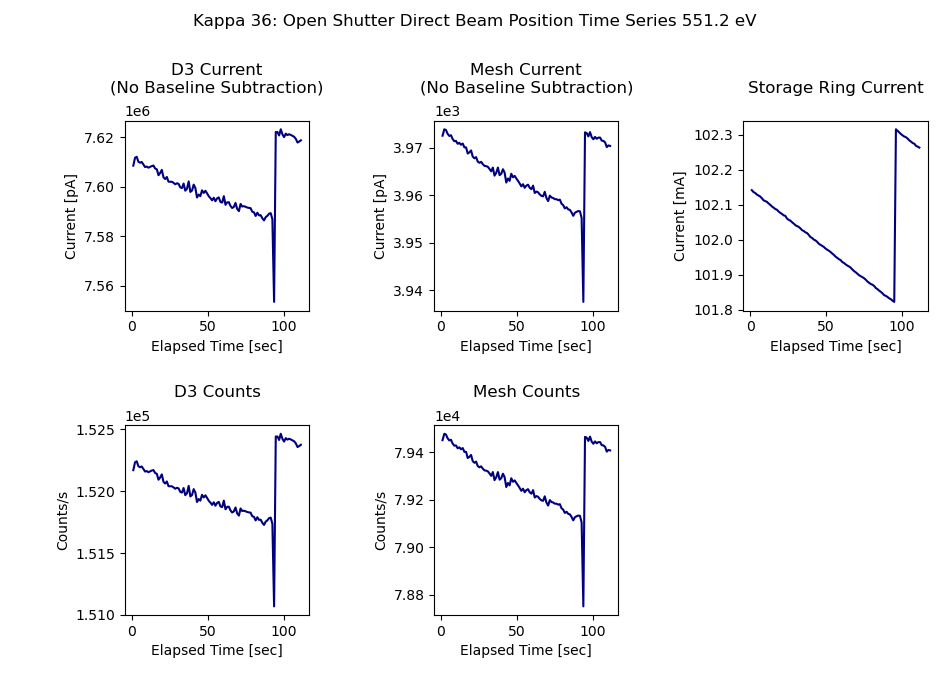

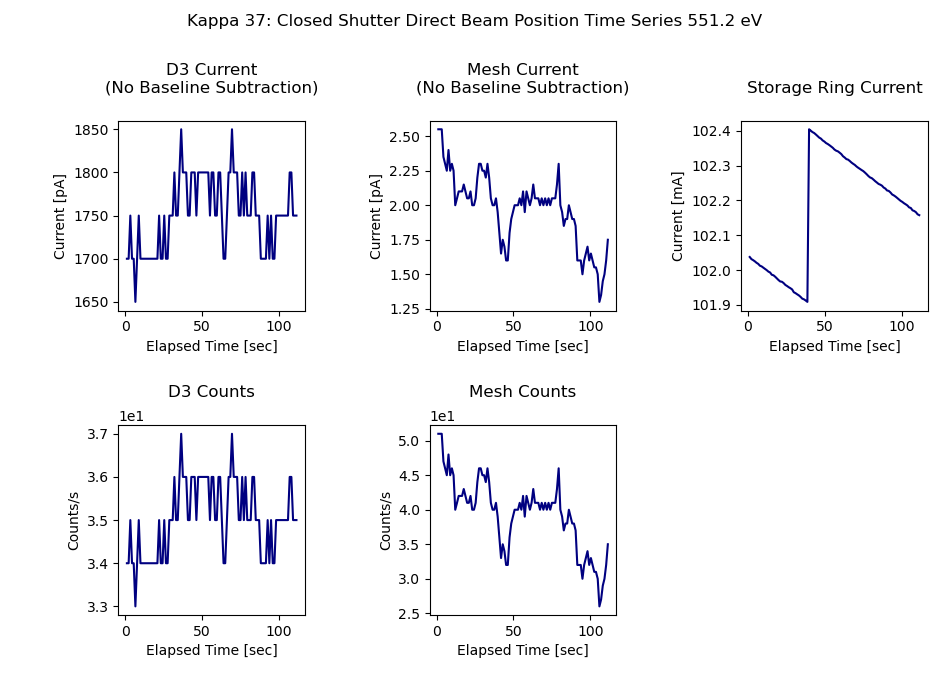

In [7]:
#-------------------------------------------------------------------------------------------------
#Kappa 36
#Open Shutter Direct Beam Position Time Series 551.2 eV
kappaNum = 36
kappaDesc = "Open Shutter Direct Beam Position Time Series 551.2 eV"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K36_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K36_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K36_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K36_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K36_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K36_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------
#Kappa 37
#Closed Shutter Direct Beam Position Time Series 551.2 eV
kappaNum = 37
kappaDesc = "Closed Shutter Direct Beam Position Time Series 551.2 eV"
data = mda.readMDA(fname=kappa_old(kappaNum), maxdim=4, verbose=0, showHelp=0)

#Positioner (x-axis: elapsed time in seconds)
K37_Positioner =data[1].p[0].data

#D3 Counts
detNum = 33
d_index = get_d_index(kappa_old(kappaNum),detNum)
K37_D3_Counts=data[1].d[d_index].data

#Mesh Counts
detNum = 31
d_index = get_d_index(kappa_old(kappaNum),detNum)
K37_Mesh_Counts=data[1].d[d_index].data

#D3 Current (No Baseline Subtraction)
detNum = 33
K37_D3_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Mesh Current (No Baseline Subtraction)
detNum = 31
K37_Mesh_Current_No_BS = calc_current(kappa_old(kappaNum),detNum,subtract_baseline = False)

#Storage Loop Current
detNum = 1
d_index = get_d_index(kappa_old(kappaNum),detNum)
K37_Storage_Loop_Current=data[1].d[d_index].data
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------

#All currents are in Amps except for Storage loop currents, which are in mA
#-------------------------------------------------------------------------------------------------
#Kappa 36
#Open Shutter Direct Beam Position Time Series 551.2 eV
OS_D_Positioner = np.array(K36_Positioner)
OS_D_D3_Counts = np.array(K36_D3_Counts)
OS_D_Mesh_Counts = np.array(K36_Mesh_Counts)
OS_D_D3_Current = np.array(K36_D3_Current_No_BS)
OS_D_Mesh_Current = np.array(K36_Mesh_Current_No_BS)
OS_D_Storage_Loop_Current = np.array(K36_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------
#Kappa 37
#Closed Shutter Direct Beam Position Time Series 551.2 eV
CS_D_Positioner = np.array(K37_Positioner)
CS_D_D3_Counts = np.array(K37_D3_Counts)
CS_D_Mesh_Counts = np.array(K37_Mesh_Counts)
CS_D_D3_Current = np.array(K37_D3_Current_No_BS)
CS_D_Mesh_Current = np.array(K37_Mesh_Current_No_BS)
CS_D_Storage_Loop_Current = np.array(K37_Storage_Loop_Current)
#-------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------
#Plotting Kappa 36
#Open Shutter Direct Beam Position Time Series
KappaNum = 36
KappaDesc = "Open Shutter Direct Beam Position Time Series 551.2 eV"
DetName = "D3"
Positioner = OS_D_Positioner
DetCounts = OS_D_D3_Counts
MeshCounts = OS_D_Mesh_Counts
DetCurrent = OS_D_D3_Current
MeshCurrent = OS_D_Mesh_Current
StorageLoopCurrent = OS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------
#Kappa 37
#Closed Shutter Direct Beam Position Time Series
KappaNum = 37
KappaDesc = "Closed Shutter Direct Beam Position Time Series 551.2 eV"
DetName = "D3"
Positioner = CS_D_Positioner
DetCounts = CS_D_D3_Counts
MeshCounts = CS_D_Mesh_Counts
DetCurrent = CS_D_D3_Current
MeshCurrent = CS_D_Mesh_Current
StorageLoopCurrent = CS_D_Storage_Loop_Current
SaveName = False

PlotGraphs(KappaNum,KappaDesc,DetName,Positioner,DetCounts,MeshCounts,DetCurrent,MeshCurrent,StorageLoopCurrent,SaveName)

data = mda.readMDA(fname=kappa_old(KappaNum), maxdim=4, verbose=0, showHelp=0)

print("Kappa " + str(KappaNum) + ": " + KappaDesc)
print("-------------------------------------------------------------------------")

print_beam_parameters(data)
print("-------------------------------------------------------------------------")

print_SRS_parameters(data,KappaNum,KappaDesc)
print("-------------------------------------------------------------------------")
print("Mean Detector Readings: ")
print("")
print("Detector Counts:  " + str(round(np.mean(DetCounts),2)) + " +/- " + str(round(np.std(DetCounts),2)) + " [Counts/s]")
print("Mesh Counts:      " + str(round(np.mean(MeshCounts),2)) + " +/- " + str(round(np.std(MeshCounts),2)) + " [Counts/s]")
print("Detector Current: " + str(round(np.mean(DetCurrent)/1e-12,2)) + " +/- " + str(round(np.std(DetCurrent)/1e-12,2)) + " [pA]")
print("Mesh Current:     " + str(round(np.mean(MeshCurrent)/1e-12,2)) + " +/- " + str(round(np.std(MeshCurrent)/1e-12,2)) + " [pA]")
print("_________________________________________________________________________________________________")
print("")

#-------------------------------------------------------------------------------------------------


## 490.0 eV Calibration

Mean Current: 6132.245544554454 [nA]
Mean Dark Current: 1.7125000000000001 [nA]
Mean (Dark Subtracted Current): 6130.533044554454 [nA]
Half Range: 24.449999999999818 [nA]
Sample Standard Deviation: 10.996660381904265 [nA]
Square Root of Mean: 78.29772055784545 [nA]
Percent Error (Half Range): 0.39882339467557276 %
Percent Error (Sample Standard Deviation): 0.17937527294909905 %
Percent Error (Square Root of Mean): 1.2771763888850527 %

Mean Counts: 122644.91089108911 [counts/s]
Mean Dark Counts: 34.25 [counts/s]
Mean (Dark Subtracted Counts): 122610.66089108911 [counts/s]
Half Range: 489.0 [counts/s]
Sample Standard Deviation: 219.93320763808777 [counts/s]
Square Root of Mean: 350.1580513012504 [counts/s]
Percent Error (Half Range): 0.3988233946755756 %
Percent Error (Sample Standard Deviation): 0.17937527294910105 %
Percent Error (Square Root of Mean): 0.2855853224804684 %


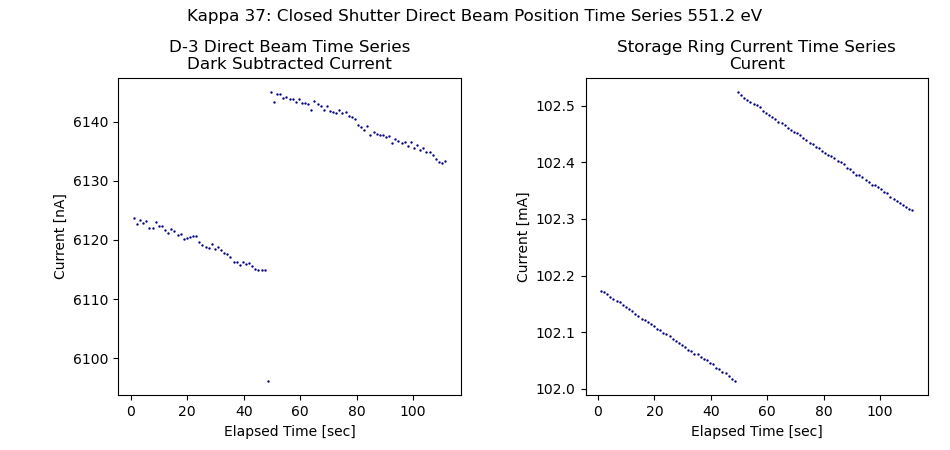

In [8]:
#Kappa 71: Open Shutter Direct Beam Position Time Series (490.0 eV)
K71_ElapsedTime = K71_Positioner
K71_Current_nA = K71_D3_Current_No_BS/1e-9
K71_Storage_Loop_Current_mA = K71_Storage_Loop_Current

#Kappa 72: Closed Shutter Direct Beam Position Time Series (490.0 eV)
K72_ElapsedTime = K72_Positioner
K72_Current_nA = K72_D3_Current_No_BS/1e-9
K72_Storage_Loop_Current_mA = K72_Storage_Loop_Current


MeanDarkCurrent_nA = np.mean(K72_Current_nA)
DarkSubCurrentArray_nA = K71_Current_nA - MeanDarkCurrent_nA 
MeanDarkSubCurrent_nA = np.mean(DarkSubCurrentArray_nA)
HalfRange_nA = (np.amax(DarkSubCurrentArray_nA) - np.amin(DarkSubCurrentArray_nA))/2
Std_nA = np.std(DarkSubCurrentArray_nA)
PctErr_HalfRange_nA = (HalfRange_nA/MeanDarkSubCurrent_nA)*100
PctErr_Std_nA = (Std_nA/MeanDarkSubCurrent_nA)*100
PctErr_SqrtMean_nA = (math.sqrt(MeanDarkSubCurrent_nA)/MeanDarkSubCurrent_nA)*100

print("Mean Current: " + str(np.mean(K71_Current_nA)) + " [nA]")
print("Mean Dark Current: " + str(MeanDarkCurrent_nA) + " [nA]")
print("Mean (Dark Subtracted Current): " + str(MeanDarkSubCurrent_nA) + " [nA]")
print("Half Range: " + str(HalfRange_nA) + " [nA]")
print("Sample Standard Deviation: " + str(Std_nA) + " [nA]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCurrent_nA)) + " [nA]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange_nA) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std_nA) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean_nA) + " %")

#Must do in counts

#Kappa 71: Open Shutter Direct Beam Position Time Series (490.0 eV)
K71_Counts = K71_D3_Counts

#Kappa 72: Closed Shutter Direct Beam Position Time Series (490.0 eV)
K72_Counts = K72_D3_Counts

MeanDarkCounts = np.mean(K72_Counts)
DarkSubCountsArray = K71_Counts - MeanDarkCounts 
MeanDarkSubCounts = np.mean(DarkSubCountsArray)
HalfRange = (np.amax(DarkSubCountsArray) - np.amin(DarkSubCountsArray))/2
Std = np.std(DarkSubCountsArray)
PctErr_HalfRange = (HalfRange/MeanDarkSubCounts)*100
PctErr_Std = (Std/MeanDarkSubCounts)*100
PctErr_SqrtMean = (math.sqrt(MeanDarkSubCounts)/MeanDarkSubCounts)*100


print("")
print("Mean Counts: " + str(np.mean(K71_Counts)) + " [counts/s]")
print("Mean Dark Counts: " + str(MeanDarkCounts) + " [counts/s]")
print("Mean (Dark Subtracted Counts): " + str(MeanDarkSubCounts) + " [counts/s]")
print("Half Range: " + str(HalfRange) + " [counts/s]")
print("Sample Standard Deviation: " + str(Std) + " [counts/s]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCounts)) + " [counts/s]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean) + " %")


f, ax = plt.subplots(1, 2)
#plt.clf()

ax[0].scatter(K71_ElapsedTime,DarkSubCurrentArray_nA, s=0.5, color="navy")
ax[0].set_title(r"D-3 Direct Beam Time Series"
             "\n" r"Dark Subtracted Current", loc = 'center')
ax[0].set_xlabel('Elapsed Time [sec]')
ax[0].set_ylabel('Current [nA]')
#ax[0,1].set_aspect(0.5)

ax[1].scatter(K71_ElapsedTime,K71_Storage_Loop_Current_mA, s=0.5, color="navy")
ax[1].set_title(r"Storage Ring Current Time Series"
             "\n" r"Curent", loc = 'center')
ax[1].set_xlabel('Elapsed Time [sec]')
ax[1].set_ylabel('Current [mA]')
#ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[1,1].set_aspect(0.5)


plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
plt.subplots_adjust(top=0.8)

figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(9.5, 4.5)

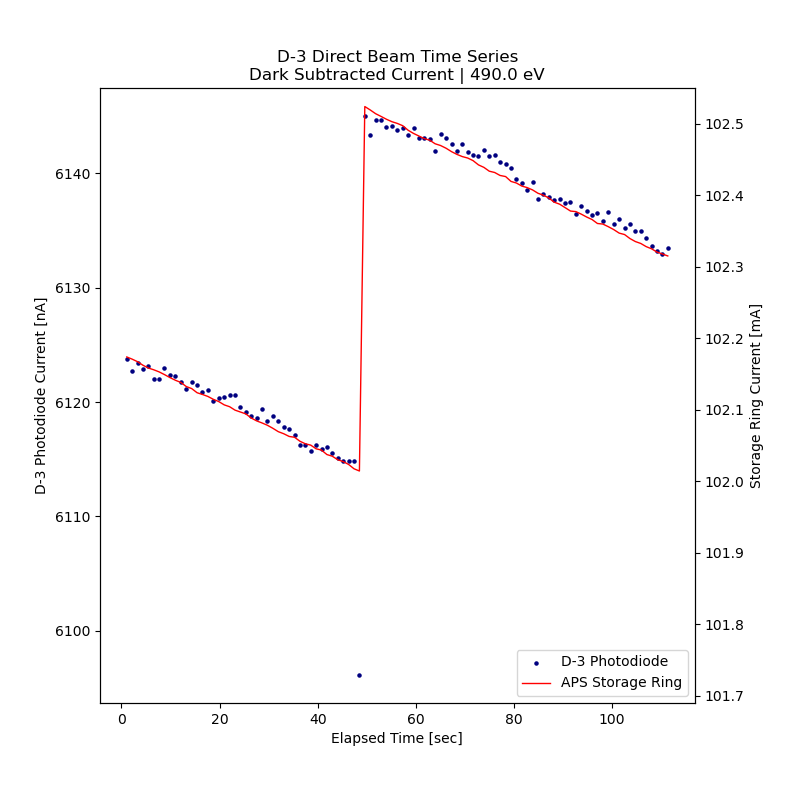

In [9]:
MeanDarkCurrent_nA = np.mean(K72_Current_nA)
DarkSubCurrentArray_nA = K71_Current_nA - MeanDarkCurrent_nA


#SMALL_SIZE = 15
#MEDIUM_SIZE = 15
#BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure()
ax = fig.add_subplot(111)


#ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
ax.set_title(r"D-3 Direct Beam Time Series"
             "\n" r"Dark Subtracted Current | 490.0 eV", loc = 'center')
ax.set_xlabel('Elapsed Time [sec]')
ax.set_ylabel('D-3 Photodiode Current [nA]')

ax2 = ax.twinx()
ax2.plot(K71_ElapsedTime,K71_Storage_Loop_Current_mA, linewidth=1.0, color="red", label = "APS Storage Ring")
ax2.set_ylabel('Storage Ring Current [mA]')
#ax2.set_ylim([101.7, 102.55])
#ax2.set_ylim([101.7, 102.56])
#ax2.set_ylim([101.68, 102.56])
ax2.set_ylim([101.69, 102.55])
ax.scatter(K71_ElapsedTime,DarkSubCurrentArray_nA , s=5, color="navy", label = "D-3 Photodiode")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

#plt.subplots_adjust(top=0.8)

figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(8, 8)

In [10]:
#<John's Singelton Data>------------------------------------------------------------------------------------------
Gain = 10
gain_unit_string = 'uA/V'

D3_OS_counts = 94686
D3_CS_counts = 116


UPD_OS_counts = 112097
UPD_CS_counts = 75
#</>--------------------------------------------------------------------------------------------------------------

#<Dark Subtract with Counts>
D3_DS_current_string, D3_DS_current_pA = find_current_basic2(D3_OS_counts-D3_CS_counts,Gain,gain_unit_string)
UPD_DS_current_string, UPD_DS_current_pA = find_current_basic2(UPD_OS_counts-UPD_CS_counts,Gain,gain_unit_string)

D3_DS_current_nA = D3_DS_current_pA*1e-12/1e-9
UPD_DS_current_nA = UPD_DS_current_pA*1e-12/1e-9
#</>

#<Dark Subtract with Current>
D3_OS_current_string, D3_OS_current_pA = find_current_basic2(D3_OS_counts,Gain,gain_unit_string)
D3_CS_current_string, D3_CS_current_pA = find_current_basic2(D3_CS_counts,Gain,gain_unit_string)

UPD_OS_current_string, UPD_OS_current_pA = find_current_basic2(UPD_OS_counts,Gain,gain_unit_string)
UPD_CS_current_string, UPD_CS_current_pA = find_current_basic2(UPD_CS_counts,Gain,gain_unit_string)

D3_current_pA = D3_OS_current_pA - D3_CS_current_pA #Dark Subtracted Current
UPD_current_pA = UPD_OS_current_pA - UPD_CS_current_pA #Dark Subtracted Current

D3_current_nA = D3_current_pA*1e-12/1e-9
UPD_current_nA = UPD_current_pA*1e-12/1e-9
#</>


print("With the Outlier Point Left in")
print("")
print("Dark Subtract at Counts")
print("UPD 490.0 eV Singleton Current : " + str(UPD_DS_current_nA) + " nA")
print("D3 490.0 eV Singleton Current : " + str(D3_DS_current_nA) + " nA")
print("")
print("Dark Subtract at Current")
print("UPD 490.0 eV Singleton Current : " + str(UPD_current_nA) + " nA")
print("D3 490.0 eV Singleton Current : " + str(D3_current_nA ) + " nA")
print("")
print("------------------------------------------------------------------------------------------")
#print("")

#<Error Dark Subtract with Counts>--------------------------------------------------------------------------------
#Use relitive error to find absolute error in counts, then convert counts to current
print("Error Dark Subtract at Counts")
print("")
CountsUncertainty = math.sqrt(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("UPD Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = math.sqrt(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("D3 Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

print("")

print("(Use relitive error to find absolute error in counts, then convert counts to current.)")
print("")

CountsUncertainty = (PctErr_HalfRange/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Half_Range_Error = CountsUncertainty_current_nA
print("UPD Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Standard_Deviation_Error = CountsUncertainty_current_nA 
print("UPD Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_HalfRange/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Half_Range_Error = CountsUncertainty_current_nA
print("D3 Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Standard_Deviation_Error = CountsUncertainty_current_nA
print("D3 Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Error Dark Subtract with Current>-------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Error Dark Subtract at Current")
print("")
print("(Use relitive error to find absolute error in current.)")
print("")
#Use relitive error to find absolute error in current
uncertainty_current_nA = (PctErr_HalfRange/100)*(UPD_current_nA)
print("UPD Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(UPD_current_nA)
print("UPD Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(UPD_current_nA)
print("UPD Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
uncertainty_current_nA = (PctErr_HalfRange/100)*(D3_current_nA)
print("D3 Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(D3_current_nA)
print("D3 Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(D3_current_nA)
print("D3 Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Calibration Coefficient and Error>------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Calibration Coefficient at 490.0 eV")
print("")
print("Dark Subtract at Counts")
print("")
c_counts = UPD_DS_current_nA/D3_DS_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,3)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,3)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,3)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,3)))

print("")
print("Dark Subtract at Current")
print("")
c_counts = UPD_current_nA/D3_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,3)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,3)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,3)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,3)))

#</>--------------------------------------------------------------------------------------------------------------

With the Outlier Point Left in

Dark Subtract at Counts
UPD 490.0 eV Singleton Current : 11202.199999999999 nA
D3 490.0 eV Singleton Current : 9456.999999999998 nA

Dark Subtract at Current
UPD 490.0 eV Singleton Current : 11202.199999999999 nA
D3 490.0 eV Singleton Current : 9456.999999999998 nA

------------------------------------------------------------------------------------------
Error Dark Subtract at Counts

UPD Square Root Singleton Counts Error: 33.469687778645316
D3 Square Root Singleton Counts Error: 30.752235691084316

(Use relitive error to find absolute error in counts, then convert counts to current.)

UPD Half Range Error: 44.676994318347326
UPD Standard Deviation Error: 20.093976826304193
UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: 31.99183899490703
D3 Half Range Error: 37.716728434469175
D3 Standard Deviation Error: 16.963519562796485
D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: 27.007803946977894

------------------

## 490.0 eV Calibration (Outlier Removed)

In [11]:
#Kappa 71: Open Shutter Direct Beam Position Time Series (490.0 eV)
K71_ElapsedTime = K71_Positioner
K71_Current_nA = K71_D3_Current_No_BS/1e-9
K71_Storage_Loop_Current_mA = K71_Storage_Loop_Current

#Kappa 72: Closed Shutter Direct Beam Position Time Series (490.0 eV)
K72_ElapsedTime = K72_Positioner
K72_Current_nA = K72_D3_Current_No_BS/1e-9
K72_Storage_Loop_Current_mA = K72_Storage_Loop_Current

#Getting Rid of the Outlier Point in K71
K71_Counts = K71_D3_Counts

K71_ElapsedTime2 = []
K71_Current_nA2 = []
K71_Counts2 = []


for i in range(np.size(K71_ElapsedTime)):
    if K71_Current_nA[i] < 6110:
        continue
    else: 
        K71_ElapsedTime2.append(K71_ElapsedTime[i])
        K71_Current_nA2.append(K71_Current_nA[i])
        K71_Counts2.append(K71_Counts[i])
        
K71_ElapsedTime2 = np.array(K71_ElapsedTime2)
K71_Current_nA2 = np.array(K71_Current_nA2)
K71_Counts2 = np.array(K71_Counts2)

MeanDarkCurrent_nA = np.mean(K72_Current_nA)
DarkSubCurrentArray_nA2 = K71_Current_nA2 - MeanDarkCurrent_nA
MeanDarkSubCurrent_nA2 = np.mean(DarkSubCurrentArray_nA2)
HalfRange_nA2 = (np.amax(DarkSubCurrentArray_nA2) - np.amin(DarkSubCurrentArray_nA2))/2
Std_nA2 = np.std(DarkSubCurrentArray_nA2)
PctErr_HalfRange_nA2 = (HalfRange_nA2/MeanDarkSubCurrent_nA2)*100
PctErr_Std_nA2 = (Std_nA/MeanDarkSubCurrent_nA2)*100
PctErr_SqrtMean_nA2 = (math.sqrt(MeanDarkSubCurrent_nA2)/MeanDarkSubCurrent_nA2)*100

print("Mean Current: " + str(np.mean(K71_Current_nA2)) + " [nA]")
print("Mean Dark Current: " + str(MeanDarkCurrent_nA) + " [nA]")
print("Mean (Dark Subtracted Current): " + str(MeanDarkSubCurrent_nA2) + " [nA]")
print("Half Range: " + str(HalfRange_nA2) + " [nA]")
print("Sample Standard Deviation: " + str(Std_nA2) + " [nA]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCurrent_nA2)) + " [nA]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange_nA2) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std_nA2) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean_nA2) + " %")

#Must do in counts

#Kappa 71: Open Shutter Direct Beam Position Time Series (490.0 eV)
K71_Counts = K71_D3_Counts

#Kappa 72: Closed Shutter Direct Beam Position Time Series (490.0 eV)
K72_Counts = K72_D3_Counts

MeanDarkCounts = np.mean(K72_Counts)
DarkSubCountsArray2 = K71_Counts2 - MeanDarkCounts 
MeanDarkSubCounts2 = np.mean(DarkSubCountsArray2)
HalfRange = (np.amax(DarkSubCountsArray2) - np.amin(DarkSubCountsArray2))/2
Std = np.std(DarkSubCountsArray2)
PctErr_HalfRange = (HalfRange/MeanDarkSubCounts2)*100
PctErr_Std = (Std/MeanDarkSubCounts2)*100
PctErr_SqrtMean = (math.sqrt(MeanDarkSubCounts2)/MeanDarkSubCounts2)*100


print("")
print("Mean Counts: " + str(np.mean(K71_Counts2)) + " [counts/s]")
print("Mean Dark Counts: " + str(MeanDarkCounts) + " [counts/s]")
print("Mean (Dark Subtracted Counts): " + str(MeanDarkSubCounts2) + " [counts/s]")
print("Half Range: " + str(HalfRange) + " [counts/s]")
print("Sample Standard Deviation: " + str(Std) + " [counts/s]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCounts2)) + " [counts/s]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean) + " %")

Mean Current: 6132.589499999998 [nA]
Mean Dark Current: 1.7125000000000001 [nA]
Mean (Dark Subtracted Current): 6130.8769999999995 [nA]
Half Range: 15.100000000000364 [nA]
Sample Standard Deviation: 10.496997892254624 [nA]
Square Root of Mean: 78.29991698590746 [nA]
Percent Error (Half Range): 0.24629429036009637 %
Percent Error (Sample Standard Deviation): 0.17936520960874383 %
Percent Error (Square Root of Mean): 1.2771405622051701 %

Mean Counts: 122651.79 [counts/s]
Mean Dark Counts: 34.25 [counts/s]
Mean (Dark Subtracted Counts): 122617.54 [counts/s]
Half Range: 302.0 [counts/s]
Sample Standard Deviation: 209.93995784509437 [counts/s]
Square Root of Mean: 350.16787402615904 [counts/s]
Percent Error (Half Range): 0.24629429036009043 %
Percent Error (Sample Standard Deviation): 0.1712152746214729 %
Percent Error (Square Root of Mean): 0.2855773113913059 %


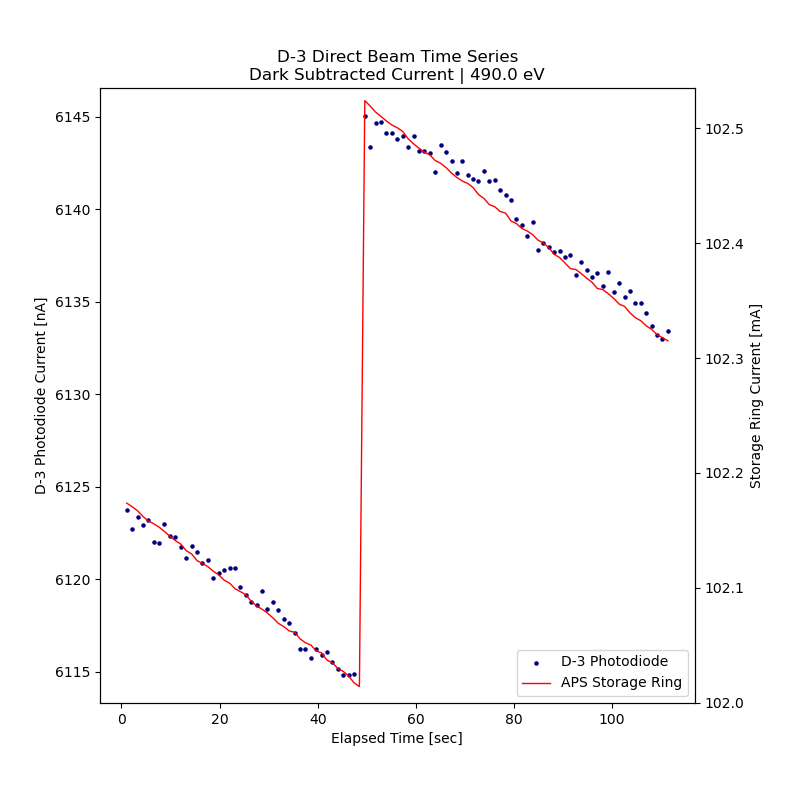

In [12]:
#SMALL_SIZE = 15
#MEDIUM_SIZE = 15
#BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure()
ax = fig.add_subplot(111)


ax.set_title(r"D-3 Direct Beam Time Series"
             "\n" r"Dark Subtracted Current | 490.0 eV", loc = 'center')
ax.set_xlabel('Elapsed Time [sec]')
ax.set_ylabel('D-3 Photodiode Current [nA]')

ax2 = ax.twinx()
ax2.plot(K71_ElapsedTime,K71_Storage_Loop_Current_mA, linewidth=1.0, color="red", label = "APS Storage Ring")
ax2.set_ylabel('Storage Ring Current [mA]')
#ax2.set_ylim([101.7, 102.55])
#ax2.set_ylim([101.7, 102.56])
#ax2.set_ylim([101.68, 102.56])
#ax2.set_ylim([101.69, 102.55])
ax2.set_ylim([102.00, 102.54])
ax2.set_ylim([102.00, 102.535])
ax.scatter(K71_ElapsedTime2,DarkSubCurrentArray_nA2 , s=5, color="navy", label = "D-3 Photodiode")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

#plt.subplots_adjust(top=0.8)

figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(8, 8)

In [20]:
#<John's Singelton Data>------------------------------------------------------------------------------------------
Gain = 10
gain_unit_string = 'uA/V'

D3_OS_counts = 94686
D3_CS_counts = 116


UPD_OS_counts = 112097
UPD_CS_counts = 75
#</>--------------------------------------------------------------------------------------------------------------

#<Dark Subtract with Counts>
D3_DS_current_string, D3_DS_current_pA = find_current_basic2(D3_OS_counts-D3_CS_counts,Gain,gain_unit_string)
UPD_DS_current_string, UPD_DS_current_pA = find_current_basic2(UPD_OS_counts-UPD_CS_counts,Gain,gain_unit_string)

D3_DS_current_nA = D3_DS_current_pA*1e-12/1e-9
UPD_DS_current_nA = UPD_DS_current_pA*1e-12/1e-9
#</>

#<Dark Subtract with Current>
D3_OS_current_string, D3_OS_current_pA = find_current_basic2(D3_OS_counts,Gain,gain_unit_string)
D3_CS_current_string, D3_CS_current_pA = find_current_basic2(D3_CS_counts,Gain,gain_unit_string)

UPD_OS_current_string, UPD_OS_current_pA = find_current_basic2(UPD_OS_counts,Gain,gain_unit_string)
UPD_CS_current_string, UPD_CS_current_pA = find_current_basic2(UPD_CS_counts,Gain,gain_unit_string)

D3_current_pA = D3_OS_current_pA - D3_CS_current_pA #Dark Subtracted Current
UPD_current_pA = UPD_OS_current_pA - UPD_CS_current_pA #Dark Subtracted Current

D3_current_nA = D3_current_pA*1e-12/1e-9
UPD_current_nA = UPD_current_pA*1e-12/1e-9
#</>


print("With the Outlier Point Removed")
print("")
print("Dark Subtract at Counts")
print("UPD 490.0 eV Singleton Current : " + str(UPD_DS_current_nA) + " nA")
print("D3 490.0 eV Singleton Current : " + str(D3_DS_current_nA) + " nA")
print("")
print("Dark Subtract at Current")
print("UPD 490.0 eV Singleton Current : " + str(UPD_current_nA) + " nA")
print("D3 490.0 eV Singleton Current : " + str(D3_current_nA ) + " nA")
print("")
print("------------------------------------------------------------------------------------------")
#print("")

#<Error Dark Subtract with Counts>--------------------------------------------------------------------------------
#Use relitive error to find absolute error in counts, then convert counts to current
print("Error Dark Subtract at Counts")
print("")
CountsUncertainty = math.sqrt(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("UPD Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = math.sqrt(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("D3 Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

print("")

print("(Use relitive error to find absolute error in counts, then convert counts to current.)")
print("")

CountsUncertainty = (PctErr_HalfRange/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Half_Range_Error = CountsUncertainty_current_nA
print("UPD Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Standard_Deviation_Error = CountsUncertainty_current_nA 
print("UPD Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_HalfRange/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Half_Range_Error = CountsUncertainty_current_nA
print("D3 Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Standard_Deviation_Error = CountsUncertainty_current_nA
print("D3 Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Error Dark Subtract with Current>-------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Error Dark Subtract at Current")
print("")
print("(Use relitive error to find absolute error in current.)")
print("")
#Use relitive error to find absolute error in current
uncertainty_current_nA = (PctErr_HalfRange/100)*(UPD_current_nA)
print("UPD Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(UPD_current_nA)
print("UPD Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(UPD_current_nA)
print("UPD Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
uncertainty_current_nA = (PctErr_HalfRange/100)*(D3_current_nA)
print("D3 Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(D3_current_nA)
print("D3 Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(D3_current_nA)
print("D3 Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Calibration Coefficient and Error>------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Calibration Coefficient at 490.0 eV")
print("")
print("Dark Subtract at Counts")
print("")
c_counts = UPD_DS_current_nA/D3_DS_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,3)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
err_c_counts_half_range = err_c_counts
print("Half Range Error: " + str(round(err_c_counts,4)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,3)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,3)))

print("")
print("Dark Subtract at Current")
print("")
c_counts = UPD_current_nA/D3_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,3)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,4)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,3)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,3)))

#</>--------------------------------------------------------------------------------------------------------------

With the Outlier Point Removed

Dark Subtract at Counts
UPD 490.0 eV Singleton Current : 11202.199999999999 nA
D3 490.0 eV Singleton Current : 9456.999999999998 nA

Dark Subtract at Current
UPD 490.0 eV Singleton Current : 11202.199999999999 nA
D3 490.0 eV Singleton Current : 9456.999999999998 nA

------------------------------------------------------------------------------------------
Error Dark Subtract at Counts

UPD Square Root Singleton Counts Error: 33.469687778645316
D3 Square Root Singleton Counts Error: 30.752235691084316

(Use relitive error to find absolute error in counts, then convert counts to current.)

UPD Half Range Error: 27.12210426579975
UPD Standard Deviation Error: 15.490690324857194
UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: 28.733560347346877
D3 Half Range Error: 22.896729217624056
D3 Standard Deviation Error: 13.077382871415839
D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: 24.25713522387204

-------------------

In [21]:
print("c = " + str(c_counts))
print("dc = " + str(err_c_counts_half_range))

c = 1.1845405519720842
dc = 0.0040558789989205025


### 490.0 Calibration Conclusions

As expected, it makes no difference if I subtract the dark signal while still in units of counts, or if I convert to current first before subtracting.

If the outlier point is not removed the greatest error comes from Half Range Error (Time Series Relitive).

UPD 490.0 eV Singleton Current : 11202 $\pm$ 45 nA

D3 490.0 eV Singleton Current : 9457 $\pm$ 38 nA

c: 1.185 $\pm$ 0.007

*

If the outlier point is removed the greatest error comes from Square Root Singleton Counts Error (Poisson).

UPD 490.0 eV Singleton Current : 11202 $\pm$ 33 nA

D3 490.0 eV Singleton Current : 9457 $\pm$ 31 nA

c: 1.185 $\pm$ 0.005

However if I go with the Half Range Error with the outlier removed, as suggested by Phil and Casey, we get:

c: 1.185 $\pm$ 0.004

This is the number that we go with in the end. c = 1.185 $\pm$ 0.004

## 551.2 eV Calibration

Mean Current: 7600.999009900988 [nA]
Mean Dark Current: 1.7514851485148513 [nA]
Mean (Dark Subtracted Current): 7599.247524752475 [nA]
Half Range: 34.850000000000364 [nA]
Sample Standard Deviation: 11.487237817816379 [nA]
Square Root of Mean: 87.17366302245463 [nA]
Percent Error (Half Range): 0.458598037325222 %
Percent Error (Sample Standard Deviation): 0.1511628326409929 %
Percent Error (Square Root of Mean): 1.1471354596426846 %

Mean Counts: 152019.9801980198 [counts/s]
Mean Dark Counts: 35.02970297029703 [counts/s]
Mean (Dark Subtracted Counts): 151984.95049504947 [counts/s]
Half Range: 697.0 [counts/s]
Sample Standard Deviation: 229.74475635632712 [counts/s]
Square Root of Mean: 389.85247273173667 [counts/s]
Percent Error (Half Range): 0.4585980373252173 %
Percent Error (Sample Standard Deviation): 0.15116283264099262 %
Percent Error (Square Root of Mean): 0.256507286716151 %


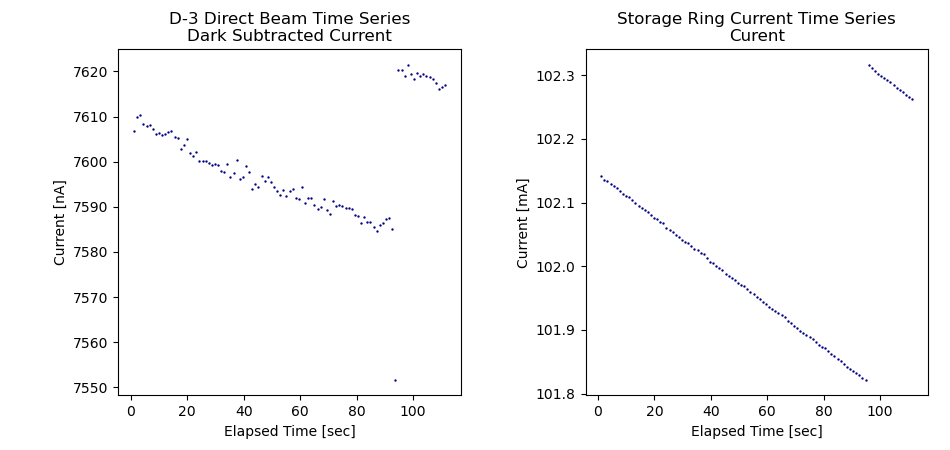

In [15]:
#Kappa 36: Open Shutter Direct Beam Position Time Series (551.2 eV)
K36_ElapsedTime = K36_Positioner
K36_Current_nA = K36_D3_Current_No_BS/1e-9
K36_Storage_Loop_Current_mA = K36_Storage_Loop_Current

#Kappa 37: Closed Shutter Direct Beam Position Time Series (551.2 eV)
K37_ElapsedTime = K37_Positioner
K37_Current_nA = K37_D3_Current_No_BS/1e-9
K37_Storage_Loop_Current_mA = K37_Storage_Loop_Current


MeanDarkCurrent_nA = np.mean(K37_Current_nA)
DarkSubCurrentArray_nA = K36_Current_nA - MeanDarkCurrent_nA 
MeanDarkSubCurrent_nA = np.mean(DarkSubCurrentArray_nA)
HalfRange_nA = (np.amax(DarkSubCurrentArray_nA) - np.amin(DarkSubCurrentArray_nA))/2
Std_nA = np.std(DarkSubCurrentArray_nA)
PctErr_HalfRange_nA = (HalfRange_nA/MeanDarkSubCurrent_nA)*100
PctErr_Std_nA = (Std_nA/MeanDarkSubCurrent_nA)*100
PctErr_SqrtMean_nA = (math.sqrt(MeanDarkSubCurrent_nA)/MeanDarkSubCurrent_nA)*100

print("Mean Current: " + str(np.mean(K36_Current_nA)) + " [nA]")
print("Mean Dark Current: " + str(MeanDarkCurrent_nA) + " [nA]")
print("Mean (Dark Subtracted Current): " + str(MeanDarkSubCurrent_nA) + " [nA]")
print("Half Range: " + str(HalfRange_nA) + " [nA]")
print("Sample Standard Deviation: " + str(Std_nA) + " [nA]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCurrent_nA)) + " [nA]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange_nA) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std_nA) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean_nA) + " %")

#Must do in counts

#Kappa 36: Open Shutter Direct Beam Position Time Series (551.2 eV)
K36_Counts = K36_D3_Counts

#Kappa 37: Closed Shutter Direct Beam Position Time Series (551.2 eV)
K37_Counts = K37_D3_Counts

MeanDarkCounts = np.mean(K37_Counts)
DarkSubCountsArray = K36_Counts - MeanDarkCounts 
MeanDarkSubCounts = np.mean(DarkSubCountsArray)
HalfRange = (np.amax(DarkSubCountsArray) - np.amin(DarkSubCountsArray))/2
Std = np.std(DarkSubCountsArray)
PctErr_HalfRange = (HalfRange/MeanDarkSubCounts)*100
PctErr_Std = (Std/MeanDarkSubCounts)*100
PctErr_SqrtMean = (math.sqrt(MeanDarkSubCounts)/MeanDarkSubCounts)*100


print("")
print("Mean Counts: " + str(np.mean(K36_Counts)) + " [counts/s]")
print("Mean Dark Counts: " + str(MeanDarkCounts) + " [counts/s]")
print("Mean (Dark Subtracted Counts): " + str(MeanDarkSubCounts) + " [counts/s]")
print("Half Range: " + str(HalfRange) + " [counts/s]")
print("Sample Standard Deviation: " + str(Std) + " [counts/s]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCounts)) + " [counts/s]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean) + " %")


f, ax = plt.subplots(1, 2)
#plt.clf()

ax[0].scatter(K36_ElapsedTime,DarkSubCurrentArray_nA, s=0.5, color="navy")
#ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
ax[0].set_title(r"D-3 Direct Beam Time Series"
             "\n" r"Dark Subtracted Current", loc = 'center')
ax[0].set_xlabel('Elapsed Time [sec]')
ax[0].set_ylabel('Current [nA]')
#ax[0,1].set_aspect(0.5)

ax[1].scatter(K36_ElapsedTime,K36_Storage_Loop_Current_mA, s=0.5, color="navy")
ax[1].set_title(r"Storage Ring Current Time Series"
             "\n" r"Curent", loc = 'center')
ax[1].set_xlabel('Elapsed Time [sec]')
ax[1].set_ylabel('Current [mA]')
#ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[1,1].set_aspect(0.5)


#plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
#plt.subplots_adjust(top=0.8)

figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(9.5, 4.5)

In [16]:
#<John's Singelton Data>------------------------------------------------------------------------------------------
#Energy = 551.2 eV
Gain = 10
gain_unit_string = 'uA/V'

D3_OS_counts = 119201
D3_CS_counts = 114


UPD_OS_counts = 135156
UPD_CS_counts = 114
#</>--------------------------------------------------------------------------------------------------------------

#<Dark Subtract with Counts>
D3_DS_current_string, D3_DS_current_pA = find_current_basic2(D3_OS_counts-D3_CS_counts,Gain,gain_unit_string)
UPD_DS_current_string, UPD_DS_current_pA = find_current_basic2(UPD_OS_counts-UPD_CS_counts,Gain,gain_unit_string)

D3_DS_current_nA = D3_DS_current_pA*1e-12/1e-9
UPD_DS_current_nA = UPD_DS_current_pA*1e-12/1e-9
#</>

#<Dark Subtract with Current>
D3_OS_current_string, D3_OS_current_pA = find_current_basic2(D3_OS_counts,Gain,gain_unit_string)
D3_CS_current_string, D3_CS_current_pA = find_current_basic2(D3_CS_counts,Gain,gain_unit_string)

UPD_OS_current_string, UPD_OS_current_pA = find_current_basic2(UPD_OS_counts,Gain,gain_unit_string)
UPD_CS_current_string, UPD_CS_current_pA = find_current_basic2(UPD_CS_counts,Gain,gain_unit_string)

D3_current_pA = D3_OS_current_pA - D3_CS_current_pA #Dark Subtracted Current
UPD_current_pA = UPD_OS_current_pA - UPD_CS_current_pA #Dark Subtracted Current

D3_current_nA = D3_current_pA*1e-12/1e-9
UPD_current_nA = UPD_current_pA*1e-12/1e-9
#</>


print("With the Outlier Point Left in")
print("")
print("Dark Subtract at Counts")
print("UPD 551.2 eV Singleton Current : " + str(UPD_DS_current_nA) + " nA")
print("D3 551.2 eV Singleton Current : " + str(D3_DS_current_nA) + " nA")
print("")
print("Dark Subtract at Current")
print("UPD 551.2 eV Singleton Current : " + str(UPD_current_nA) + " nA")
print("D3 551.2 eV Singleton Current : " + str(D3_current_nA ) + " nA")
print("")
print("------------------------------------------------------------------------------------------")
#print("")

#<Error Dark Subtract with Counts>--------------------------------------------------------------------------------
#Use relitive error to find absolute error in counts, then convert counts to current
print("Error Dark Subtract at Counts")
print("")
CountsUncertainty = math.sqrt(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("UPD Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = math.sqrt(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("D3 Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

print("")

print("(Use relitive error to find absolute error in counts, then convert counts to current.)")
print("")

CountsUncertainty = (PctErr_HalfRange/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Half_Range_Error = CountsUncertainty_current_nA
print("UPD Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Standard_Deviation_Error = CountsUncertainty_current_nA 
print("UPD Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_HalfRange/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Half_Range_Error = CountsUncertainty_current_nA
print("D3 Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Standard_Deviation_Error = CountsUncertainty_current_nA
print("D3 Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Error Dark Subtract with Current>-------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Error Dark Subtract at Current")
print("")
print("(Use relitive error to find absolute error in current.)")
print("")
#Use relitive error to find absolute error in current
uncertainty_current_nA = (PctErr_HalfRange/100)*(UPD_current_nA)
print("UPD Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(UPD_current_nA)
print("UPD Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(UPD_current_nA)
print("UPD Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
uncertainty_current_nA = (PctErr_HalfRange/100)*(D3_current_nA)
print("D3 Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(D3_current_nA)
print("D3 Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(D3_current_nA)
print("D3 Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Calibration Coefficient and Error>------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Calibration Coefficient at 551.2 eV")
print("")
print("Dark Subtract at Counts")
print("")
c_counts = UPD_DS_current_nA/D3_DS_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,3)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,3)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,3)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,3)))

print("")
print("Dark Subtract at Current")
print("")
c_counts = UPD_current_nA/D3_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,4)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,4)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,4)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,4)))

#</>--------------------------------------------------------------------------------------------------------------

With the Outlier Point Left in

Dark Subtract at Counts
UPD 551.2 eV Singleton Current : 13504.199999999999 nA
D3 551.2 eV Singleton Current : 11908.699999999997 nA

Dark Subtract at Current
UPD 551.2 eV Singleton Current : 13504.199999999997 nA
D3 551.2 eV Singleton Current : 11908.699999999999 nA

------------------------------------------------------------------------------------------
Error Dark Subtract at Counts

UPD Square Root Singleton Counts Error: 36.74806117334628
D3 Square Root Singleton Counts Error: 34.50898433741567

(Use relitive error to find absolute error in counts, then convert counts to current.)

UPD Half Range Error: 61.929996156471994
UPD Standard Deviation Error: 20.413331245504917
UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: 34.63925701272245
D3 Half Range Error: 54.613064470948146
D3 Standard Deviation Error: 18.001528250717886
D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: 30.546683253166265

------------------

## 551.2 eV Calibration (Outlier Removed)

Outlier Removed

Mean Current: 7601.474499999999 [nA]
Mean Dark Current: 1.7514851485148513 [nA]
Mean (Dark Subtracted Current): 7599.723014851485 [nA]
Half Range: 18.40000000000009 [nA]
Sample Standard Deviation: 10.509092479848116 [nA]
Square Root of Mean: 87.1763902375608 [nA]
Percent Error (Half Range): 0.24211408710610316 %
Percent Error (Sample Standard Deviation): 0.13828257239521888 %
Percent Error (Square Root of Mean): 1.1470995728028441 %

Mean Counts: 152029.49 [counts/s]
Mean Dark Counts: 35.02970297029703 [counts/s]
Mean (Dark Subtracted Counts): 151994.4602970297 [counts/s]
Half Range: 368.0 [counts/s]
Sample Standard Deviation: 210.1818495969621 [counts/s]
Square Root of Mean: 389.86466920846993 [counts/s]
Percent Error (Half Range): 0.24211408710610194 %
Percent Error (Sample Standard Deviation): 0.13828257239521877 %
Percent Error (Square Root of Mean): 0.2564992621748128 %


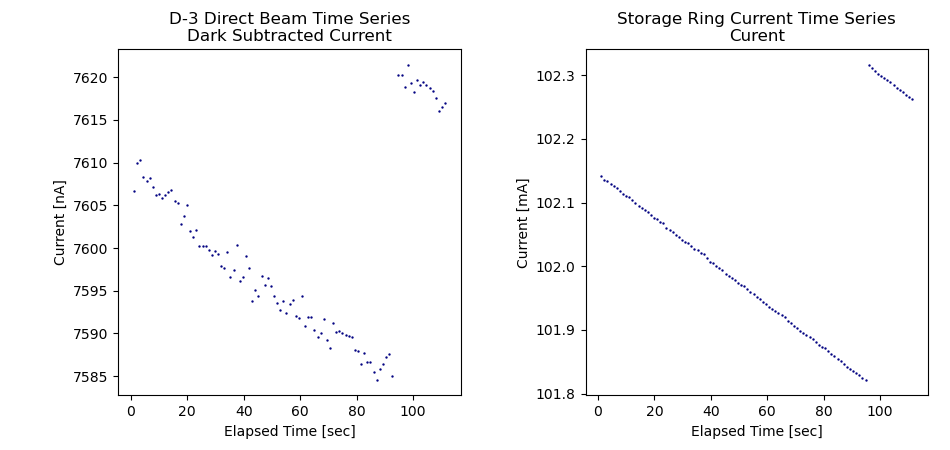

In [17]:
#Kappa 36: Open Shutter Direct Beam Position Time Series (551.2 eV)
K36_ElapsedTime = K36_Positioner
K36_Current_nA = K36_D3_Current_No_BS/1e-9
K36_Storage_Loop_Current_mA = K36_Storage_Loop_Current

#Kappa 37: Closed Shutter Direct Beam Position Time Series (551.2 eV)
K37_ElapsedTime = K37_Positioner
K37_Current_nA = K37_D3_Current_No_BS/1e-9
K37_Storage_Loop_Current_mA = K37_Storage_Loop_Current

#Getting Rid of the Outlier Point in K71
K36_Counts = K36_D3_Counts

K36_ElapsedTime2 = []
K36_Current_nA2 = []
K36_Counts2 = []


for i in range(np.size(K36_ElapsedTime)):
    if K36_Current_nA[i] < 7580:
        continue
    else: 
        K36_ElapsedTime2.append(K36_ElapsedTime[i])
        K36_Current_nA2.append(K36_Current_nA[i])
        K36_Counts2.append(K36_Counts[i])

K36_ElapsedTimeB = K36_ElapsedTime
K36_ElapsedTime = np.array(K36_ElapsedTime2)
K36_Current_nA = np.array(K36_Current_nA2)
K36_Counts = np.array(K36_Counts2)

MeanDarkCurrent_nA = np.mean(K37_Current_nA)
DarkSubCurrentArray_nA = K36_Current_nA - MeanDarkCurrent_nA 
MeanDarkSubCurrent_nA = np.mean(DarkSubCurrentArray_nA)
HalfRange_nA = (np.amax(DarkSubCurrentArray_nA) - np.amin(DarkSubCurrentArray_nA))/2
Std_nA = np.std(DarkSubCurrentArray_nA)
PctErr_HalfRange_nA = (HalfRange_nA/MeanDarkSubCurrent_nA)*100
PctErr_Std_nA = (Std_nA/MeanDarkSubCurrent_nA)*100
PctErr_SqrtMean_nA = (math.sqrt(MeanDarkSubCurrent_nA)/MeanDarkSubCurrent_nA)*100

print("Outlier Removed")
print("")

print("Mean Current: " + str(np.mean(K36_Current_nA)) + " [nA]")
print("Mean Dark Current: " + str(MeanDarkCurrent_nA) + " [nA]")
print("Mean (Dark Subtracted Current): " + str(MeanDarkSubCurrent_nA) + " [nA]")
print("Half Range: " + str(HalfRange_nA) + " [nA]")
print("Sample Standard Deviation: " + str(Std_nA) + " [nA]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCurrent_nA)) + " [nA]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange_nA) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std_nA) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean_nA) + " %")

#Must do in counts

#Kappa 36: Open Shutter Direct Beam Position Time Series (551.2 eV)
#K36_Counts = K36_D3_Counts

#Kappa 37: Closed Shutter Direct Beam Position Time Series (551.2 eV)
#K37_Counts = K37_D3_Counts

MeanDarkCounts = np.mean(K37_Counts)
DarkSubCountsArray = K36_Counts - MeanDarkCounts 
MeanDarkSubCounts = np.mean(DarkSubCountsArray)
HalfRange = (np.amax(DarkSubCountsArray) - np.amin(DarkSubCountsArray))/2
Std = np.std(DarkSubCountsArray)
PctErr_HalfRange = (HalfRange/MeanDarkSubCounts)*100
PctErr_Std = (Std/MeanDarkSubCounts)*100
PctErr_SqrtMean = (math.sqrt(MeanDarkSubCounts)/MeanDarkSubCounts)*100


print("")
print("Mean Counts: " + str(np.mean(K36_Counts)) + " [counts/s]")
print("Mean Dark Counts: " + str(MeanDarkCounts) + " [counts/s]")
print("Mean (Dark Subtracted Counts): " + str(MeanDarkSubCounts) + " [counts/s]")
print("Half Range: " + str(HalfRange) + " [counts/s]")
print("Sample Standard Deviation: " + str(Std) + " [counts/s]")
print("Square Root of Mean: " + str(math.sqrt(MeanDarkSubCounts)) + " [counts/s]")
print("Percent Error (Half Range): " + str(PctErr_HalfRange) + " %")
print("Percent Error (Sample Standard Deviation): " + str(PctErr_Std) + " %")
print("Percent Error (Square Root of Mean): " + str(PctErr_SqrtMean) + " %")


f, ax = plt.subplots(1, 2)
#plt.clf()

ax[0].scatter(K36_ElapsedTime,DarkSubCurrentArray_nA, s=0.5, color="navy")
#ax[1].set_title("D3 Current No Baseline Subtract", loc = 'center')
ax[0].set_title(r"D-3 Direct Beam Time Series"
             "\n" r"Dark Subtracted Current", loc = 'center')
ax[0].set_xlabel('Elapsed Time [sec]')
ax[0].set_ylabel('Current [nA]')
#ax[0,1].set_aspect(0.5)

ax[1].scatter(K36_ElapsedTimeB,K36_Storage_Loop_Current_mA, s=0.5, color="navy")
ax[1].set_title(r"Storage Ring Current Time Series"
             "\n" r"Curent", loc = 'center')
ax[1].set_xlabel('Elapsed Time [sec]')
ax[1].set_ylabel('Current [mA]')
#ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[1,1].set_aspect(0.5)


#plt.suptitle("Kappa " + str(KappaNum) + ": " + KappaDesc)
#plt.subplots_adjust(top=0.8)

figure = plt.gcf()
figure.tight_layout()
figure.set_size_inches(9.5, 4.5)

In [18]:
#<John's Singelton Data>------------------------------------------------------------------------------------------
#Energy = 551.2 eV
Gain = 10
gain_unit_string = 'uA/V'

D3_OS_counts = 119201
D3_CS_counts = 114


UPD_OS_counts = 135156
UPD_CS_counts = 114
#</>--------------------------------------------------------------------------------------------------------------

#<Dark Subtract with Counts>
D3_DS_current_string, D3_DS_current_pA = find_current_basic2(D3_OS_counts-D3_CS_counts,Gain,gain_unit_string)
UPD_DS_current_string, UPD_DS_current_pA = find_current_basic2(UPD_OS_counts-UPD_CS_counts,Gain,gain_unit_string)

D3_DS_current_nA = D3_DS_current_pA*1e-12/1e-9
UPD_DS_current_nA = UPD_DS_current_pA*1e-12/1e-9
#</>

#<Dark Subtract with Current>
D3_OS_current_string, D3_OS_current_pA = find_current_basic2(D3_OS_counts,Gain,gain_unit_string)
D3_CS_current_string, D3_CS_current_pA = find_current_basic2(D3_CS_counts,Gain,gain_unit_string)

UPD_OS_current_string, UPD_OS_current_pA = find_current_basic2(UPD_OS_counts,Gain,gain_unit_string)
UPD_CS_current_string, UPD_CS_current_pA = find_current_basic2(UPD_CS_counts,Gain,gain_unit_string)

D3_current_pA = D3_OS_current_pA - D3_CS_current_pA #Dark Subtracted Current
UPD_current_pA = UPD_OS_current_pA - UPD_CS_current_pA #Dark Subtracted Current

D3_current_nA = D3_current_pA*1e-12/1e-9
UPD_current_nA = UPD_current_pA*1e-12/1e-9
#</>


print("With the Outlier Point Removed")
print("")
print("Dark Subtract at Counts")
print("UPD 551.2 eV Singleton Current : " + str(UPD_DS_current_nA) + " nA")
print("D3 551.2 eV Singleton Current : " + str(D3_DS_current_nA) + " nA")
print("")
print("Dark Subtract at Current")
print("UPD 551.2 eV Singleton Current : " + str(UPD_current_nA) + " nA")
print("D3 551.2 eV Singleton Current : " + str(D3_current_nA ) + " nA")
print("")
print("------------------------------------------------------------------------------------------")
#print("")

#<Error Dark Subtract with Counts>--------------------------------------------------------------------------------
#Use relitive error to find absolute error in counts, then convert counts to current
print("Error Dark Subtract at Counts")
print("")
CountsUncertainty = math.sqrt(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("UPD Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = math.sqrt(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Singleton_Counts_Error = CountsUncertainty_current_nA
print("D3 Square Root Singleton Counts Error: " + str(CountsUncertainty_current_nA))

print("")

print("(Use relitive error to find absolute error in counts, then convert counts to current.)")
print("")

CountsUncertainty = (PctErr_HalfRange/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Half_Range_Error = CountsUncertainty_current_nA
print("UPD Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Standard_Deviation_Error = CountsUncertainty_current_nA 
print("UPD Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(UPD_OS_counts-UPD_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_HalfRange/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Half_Range_Error = CountsUncertainty_current_nA
print("D3 Half Range Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_Std/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Standard_Deviation_Error = CountsUncertainty_current_nA
print("D3 Standard Deviation Error: " + str(CountsUncertainty_current_nA))

CountsUncertainty = (PctErr_SqrtMean/100)*(D3_OS_counts-D3_CS_counts)
CountsUncertainty_current_string, CountsUncertainty_current_pA = find_current_basic2(CountsUncertainty,Gain,gain_unit_string)
CountsUncertainty_current_nA = CountsUncertainty_current_pA*1e-12/1e-9
D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute = CountsUncertainty_current_nA
print("D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(CountsUncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Error Dark Subtract with Current>-------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Error Dark Subtract at Current")
print("")
print("(Use relitive error to find absolute error in current.)")
print("")
#Use relitive error to find absolute error in current
uncertainty_current_nA = (PctErr_HalfRange/100)*(UPD_current_nA)
print("UPD Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(UPD_current_nA)
print("UPD Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(UPD_current_nA)
print("UPD Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
uncertainty_current_nA = (PctErr_HalfRange/100)*(D3_current_nA)
print("D3 Half Range Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_Std/100)*(D3_current_nA)
print("D3 Standard Deviation Error: " + str(uncertainty_current_nA))

uncertainty_current_nA = (PctErr_SqrtMean/100)*(D3_current_nA)
print("D3 Square Root Mean Dark Sub Time Series Relative Error to absolute: " + str(uncertainty_current_nA))
print("")
#</>--------------------------------------------------------------------------------------------------------------

#<Calibration Coefficient and Error>------------------------------------------------------------------------------
print("------------------------------------------------------------------------------------------")
print("Calibration Coefficient at 551.2 eV")
print("")
print("Dark Subtract at Counts")
print("")
c_counts = UPD_DS_current_nA/D3_DS_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,3)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,3)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,3)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_DS_current_nA,D3_DS_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,3)))

print("")
print("Dark Subtract at Current")
print("")
c_counts = UPD_current_nA/D3_current_nA
print("c: " + str(round(c_counts,3)))
print("")

err_a = UPD_Square_Root_Singleton_Counts_Error
err_b = D3_Square_Root_Singleton_Counts_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Singleton Counts Error (Poisson): " + str(round(err_c_counts,4)))

err_a = UPD_Half_Range_Error
err_b = D3_Half_Range_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Half Range Error: " + str(round(err_c_counts,4)))

err_a = UPD_Standard_Deviation_Error
err_b = D3_Standard_Deviation_Error
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Standard Deviation Error: " + str(round(err_c_counts,4)))

err_a = UPD_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_b = D3_Square_Root_Mean_Dark_Sub_Time_Series_Relative_Error_to_Absolute
err_c_counts = Err_a_over_b(UPD_current_nA,D3_current_nA,err_a,err_b)
print("Square Root Mean Dark Sub Time Series Relative Error to Absolute: " + str(round(err_c_counts,4)))

#</>--------------------------------------------------------------------------------------------------------------

With the Outlier Point Removed

Dark Subtract at Counts
UPD 551.2 eV Singleton Current : 13504.199999999999 nA
D3 551.2 eV Singleton Current : 11908.699999999997 nA

Dark Subtract at Current
UPD 551.2 eV Singleton Current : 13504.199999999997 nA
D3 551.2 eV Singleton Current : 11908.699999999999 nA

------------------------------------------------------------------------------------------
Error Dark Subtract at Counts

UPD Square Root Singleton Counts Error: 36.74806117334628
D3 Square Root Singleton Counts Error: 34.50898433741567

(Use relitive error to find absolute error in counts, then convert counts to current.)

UPD Half Range Error: 32.69557055098221
UPD Standard Deviation Error: 18.673955141395133
UPD Square Root Mean Dark Sub Time Series Relative Error to Absolute: 34.638173362611056
D3 Half Range Error: 28.83264029120436
D3 Standard Deviation Error: 16.467656698829416
D3 Square Root Mean Dark Sub Time Series Relative Error to Absolute: 30.54572763461192

--------------------

Why is the half range error greater now after I removed the outlier than it was before?

### 551.2 Calibration Conclusions

If the outlier point is not removed the greatest error comes from Half Range Error (Time Series Relative).

UPD 551.2 eV Singleton Current : 13504 $\pm$ 54 nA

D3 551.2 eV Singleton Current : 11909 $\pm$ 47 nA

c: 1.134 $\pm$ 0.006 

*

If the outlier point is removed the greatest error comes from Square Root Singleton Counts Error (Poisson).

UPD 551.2 eV Singleton Current : 13504 $\pm$ 37 nA

D3 551.2 eV Singleton Current : 11909 $\pm$ 35 nA

c: 1.134 $\pm$ 0.005



# Calibration Conclusions

As expected, it makes no difference if I subtract the dark signal while still in units of counts, or if I convert to current first before subtracting.

### 490.0 eV

If the outlier point is not removed the greatest error comes from Half Range Error (Time Series Relative).

UPD 490.0 eV Singleton Current : 11202 $\pm$ 45 nA

D3 490.0 eV Singleton Current : 9457 $\pm$ 38 nA

c: 1.185 $\pm$ 0.007

*

If the outlier point is removed the greatest error comes from Square Root Singleton Counts Error (Poisson).

UPD 490.0 eV Singleton Current : 11202 $\pm$ 33 nA

D3 490.0 eV Singleton Current : 9457 $\pm$ 31 nA

c: 1.185 $\pm$ 0.005

I still need to work out the relative error from the UPD 490.5 eV UPD time series to see if it compares to what I'm finding here.

### 551.2 eV

If the outlier point is not removed the greatest error comes from Half Range Error (Time Series Relative).

UPD 551.2 eV Singleton Current : 13504 $\pm$ 54 nA

D3 551.2 eV Singleton Current : 11909 $\pm$ 47 nA

c: 1.134 $\pm$ 0.006 

*

If the outlier point is removed the greatest error comes from Square Root Singleton Counts Error (Poisson).

UPD 551.2 eV Singleton Current : 13504 $\pm$ 37 nA

D3 551.2 eV Singleton Current : 11909 $\pm$ 35 nA

c: 1.134 $\pm$ 0.005


Phil and Casey say I should use the dark subtracted half range 

551.2 eV

UPD Half Range Error: 32.69557055098221
D3 Half Range Error: 28.83264029120436
c Half Range Error: 0.004

This is the half range error with the one outlier removed (scroll back up to the 490.0 eV calibration to see where this number came from)

In [19]:
print(np.size(K42_Positioner))

601
